# 02. Data Preprocessing - Credit Card Fraud Detaction 

- Sophisticated Preprocessing Pipeline Using Pure NumPy

## Overview 
- [1. Import and Setup](#1-import-and-setup)
- [2. Loading data and previous analysis results](#2-loading-data-and-previous-analysis-results)
- [3. Configuring advanced preprocessing pipeline](#3-configuring-advanced-preprocessing-pipiline)
- [4. Avanced missnig values handling](#4-advanced-missing-value-handling)
- [5. Outlier dectection and handling](#5-outlier-detection-and-handing)
- [6. Feature scaling](#6-feature-scaling)
- [7. Avanced class imbalance handlling](#7-advanced-class-imbalance-handling)
- [8. Feature engineering](#8-feature-engineering)
- [9. Feature selection](#9-feature-selection)
- [10. Summary and saving](#10-summary-and-save)

### 1. Import and Setup 

#### 1.1. Import library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import sys
import os
from pathlib import Path
import warnings
import joblib
import time
from scipy import stats
from scipy.spatial.distance import cdist
import math

#### 1.2. Add path to import modules

In [2]:
sys.path.append('..')
sys.path.append('../src')
sys.path.insert(0, str(Path('..').resolve()))
sys.path.insert(0, str(Path('../src').resolve()))

#### 1.3. Import custom modules

In [3]:
from src.data_processing import (
    AdvancedPreprocessor, 
    PreprocessingConfig,
    compute_correlation_matrix,
    detect_highly_correlated_features,
    analyze_class_imbalance,
    NumpyDataProcessor,
    DataStats
)
from src.visualization import AdvancedVisualizer, PlotConfig

#### 1.4. Setup 

In [4]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
warnings.filterwarnings('ignore')
np.set_printoptions(precision=4, suppress=True)

print('Preprocessing Pipeline Initialized!')

Preprocessing Pipeline Initialized!


### 2. Loading data and previous analysis results

In [5]:
print("=" * 80)
print("📊 LOADING DATA AND PREVIOUS ANALYSIS RESULTS")
print("=" * 80)

# Tải dữ liệu đã xử lý từ bước exploration
try:
    with open('../data/processed/exploration_results.pkl', 'rb') as f:
        exploration_results = joblib.load(f)
    
    # Tải dữ liệu gốc
    processor = NumpyDataProcessor()
    X, y = processor.load_data('../data/raw/creditcard.csv', 
                              delimiter=',', 
                              skip_header=1, 
                              target_col=-1)
    
    print("✅ Data and analysis results loaded successfully!")
    print(f"📊 Dataset shape: {X.shape}")
    print(f"🎯 Target distribution: {np.unique(y, return_counts=True)}")
    
    # Hiển thị thông tin từ exploration
    feature_stats = exploration_results.get('feature_stats', {})
    print(f"\n📈 Available statistics for {X.shape[1]} features")
    print(f"🔍 Missing values: {np.isnan(X).sum()}")
    print(f"🚨 Total outliers: {exploration_results.get('data_quality_issues', {}).get('outlier_count', 0)}")
    print(f"📊 Highly correlated pairs: {len(exploration_results.get('highly_correlated_features', []))}")
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    # Fallback: load directly
    X = np.genfromtxt('../data/raw/creditcard.csv', delimiter=',', skip_header=1)
    y = X[:, -1].astype(np.int8)
    X = X[:, :-1]
    feature_stats = {}
    print(f"Loaded directly - X: {X.shape}, y: {y.shape}")

# Hiển thị comprehensive data summary
print(f"\n" + "="*50)
print("DATA SUMMARY BEFORE PREPROCESSING")
print("="*50)
print(f"Dataset Dimensions: {X.shape}")
print(f"Memory Usage: {X.nbytes / 1024 / 1024:.2f} MB")
print(f"Data Type: {X.dtype}")
print(f"Missing Values: {np.isnan(X).sum()}")
print(f"Features with Missing Values: {np.sum(np.isnan(X).sum(axis=0) > 0)}")

# Class distribution analysis
class_counts = np.unique(y, return_counts=True)
print(f"\nClass Distribution:")
for i, (cls, count) in enumerate(zip(class_counts[0], class_counts[1])):
    percentage = (count / len(y)) * 100
    print(f"  Class {cls}: {count:,} samples ({percentage:.4f}%)")

imbalance_ratio = max(class_counts[1]) / min(class_counts[1])
print(f"Imbalance Ratio: {imbalance_ratio:.2f}:1")

# Basic data statistics
print(f"\nBasic Statistics:")
print(f"Data Range: [{np.nanmin(X):.4f}, {np.nanmax(X):.4f}]")
print(f"Mean: {np.nanmean(X):.4f}")
print(f"Std:  {np.nanstd(X):.4f}")
print(f"Median: {np.nanmedian(X):.4f}")

📊 LOADING DATA AND PREVIOUS ANALYSIS RESULTS
Data loaded in 2.97 seconds
Features shape: (284807, 30), Target shape: (284807,)
Memory usage: 65.19 MB
✅ Data and analysis results loaded successfully!
📊 Dataset shape: (284807, 30)
🎯 Target distribution: (array([0, 1], dtype=int8), array([284315,    492]))

📈 Available statistics for 30 features
🔍 Missing values: 0
🚨 Total outliers: 370372
📊 Highly correlated pairs: 0

DATA SUMMARY BEFORE PREPROCESSING
Dataset Dimensions: (284807, 30)
Memory Usage: 65.19 MB
Data Type: float64
Missing Values: 0
Features with Missing Values: 0

Class Distribution:
  Class 0: 284,315 samples (99.8273%)
  Class 1: 492 samples (0.1727%)
Imbalance Ratio: 577.88:1

Basic Statistics:
Data Range: [-113.7433, 172792.0000]
Mean: 3163.4070
Std:  19100.2968
Median: 0.0357


🔍 COMPREHENSIVE DATA ANALYSIS BEFORE PREPROCESSING


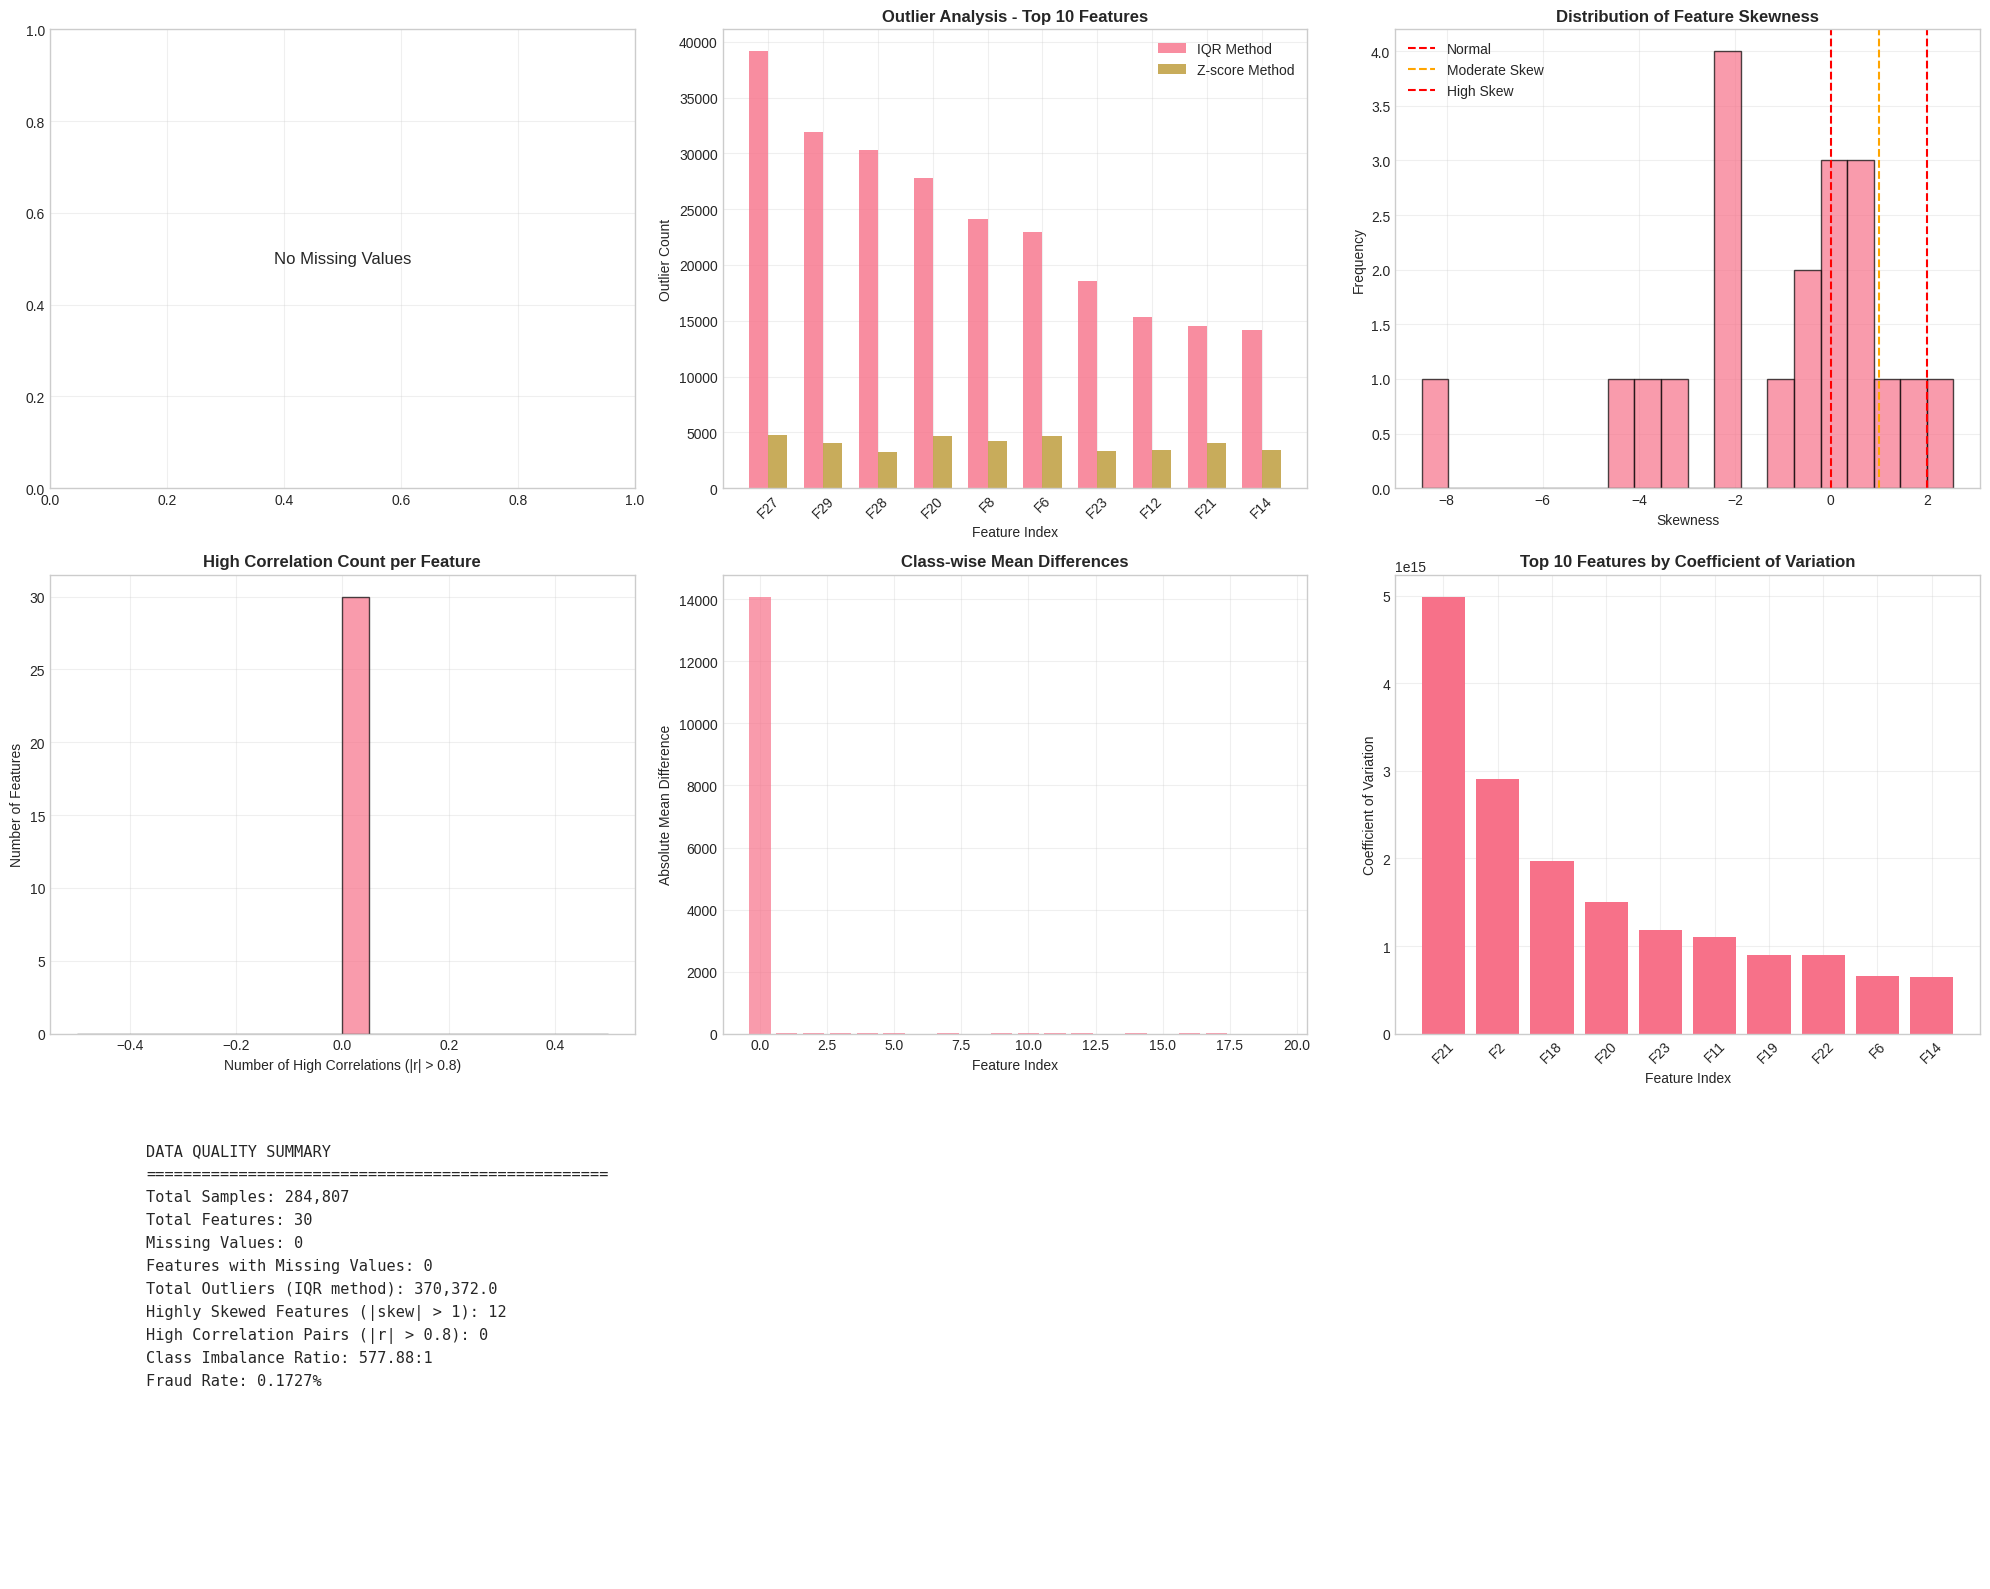

✅ Comprehensive pre-processing analysis completed!


In [6]:
print("=" * 80)
print("🔍 COMPREHENSIVE DATA ANALYSIS BEFORE PREPROCESSING")
print("=" * 80)

# Khởi tạo visualizer
viz_config = PlotConfig(figsize=(18, 14), title_fontsize=14)
visualizer = AdvancedVisualizer(viz_config)

# Tạo pre-processing analysis dashboard
fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(3, 3, figure=fig)


# 1. Missing values pattern
ax1 = fig.add_subplot(gs[0, 0])
missing_matrix = np.isnan(X)
missing_per_feature = np.sum(missing_matrix, axis=0)
features_with_missing = np.where(missing_per_feature > 0)[0]

if len(features_with_missing) > 0:
    ax1.bar(range(len(features_with_missing)), missing_per_feature[features_with_missing])
    ax1.set_title('Missing Values by Feature', fontweight='bold')
    ax1.set_xlabel('Feature Index')
    ax1.set_ylabel('Missing Count')
    ax1.set_xticks(range(len(features_with_missing)))
    ax1.set_xticklabels([f'F{idx}' for idx in features_with_missing], rotation=45)
    
    # Add percentages
    for i, idx in enumerate(features_with_missing):
        percentage = (missing_per_feature[idx] / X.shape[0]) * 100
        ax1.text(i, missing_per_feature[idx] + 0.1, f'{percentage:.1f}%', 
                ha='center', va='bottom', fontsize=8)
else:
    ax1.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', 
            transform=ax1.transAxes, fontsize=12)
ax1.grid(True, alpha=0.3)

# 2. Outlier analysis using multiple methods
ax2 = fig.add_subplot(gs[0, 1])
outlier_counts_iqr = np.zeros(X.shape[1])
outlier_counts_zscore = np.zeros(X.shape[1])

for i in range(X.shape[1]):
    feature_data = X[:, i]
    if np.std(feature_data) > 0:
        # IQR method
        q25, q75 = np.percentile(feature_data, [25, 75])
        iqr = q75 - q25
        lower_bound, upper_bound = q25 - 1.5*iqr, q75 + 1.5*iqr
        outliers_iqr = np.sum((feature_data < lower_bound) | (feature_data > upper_bound))
        outlier_counts_iqr[i] = outliers_iqr
        
        # Z-score method
        z_scores = np.abs((feature_data - np.mean(feature_data)) / np.std(feature_data))
        outliers_zscore = np.sum(z_scores > 3)
        outlier_counts_zscore[i] = outliers_zscore

# Plot top features with outliers
top_outlier_indices = np.argsort(outlier_counts_iqr)[-10:][::-1]
x_pos = np.arange(len(top_outlier_indices))
width = 0.35

ax2.bar(x_pos - width/2, outlier_counts_iqr[top_outlier_indices], width, 
        label='IQR Method', alpha=0.8)
ax2.bar(x_pos + width/2, outlier_counts_zscore[top_outlier_indices], width, 
        label='Z-score Method', alpha=0.8)

ax2.set_title('Outlier Analysis - Top 10 Features', fontweight='bold')
ax2.set_xlabel('Feature Index')
ax2.set_ylabel('Outlier Count')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'F{idx}' for idx in top_outlier_indices], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Data distribution skewness
ax3 = fig.add_subplot(gs[0, 2])
skewness_values = []
for i in range(min(20, X.shape[1])):  # Limit to first 20 features
    feature_data = X[:, i]
    if np.std(feature_data) > 0:
        from scipy import stats as scipy_stats
        skew = scipy_stats.skew(feature_data)
        skewness_values.append(skew)

ax3.hist(skewness_values, bins=20, alpha=0.7, edgecolor='black')
ax3.set_title('Distribution of Feature Skewness', fontweight='bold')
ax3.set_xlabel('Skewness')
ax3.set_ylabel('Frequency')
ax3.axvline(x=0, color='red', linestyle='--', label='Normal')
ax3.axvline(x=1, color='orange', linestyle='--', label='Moderate Skew')
ax3.axvline(x=2, color='red', linestyle='--', label='High Skew')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Feature correlation analysis
ax4 = fig.add_subplot(gs[1, 0])
corr_matrix = compute_correlation_matrix(X)
corr_abs = np.abs(corr_matrix)
np.fill_diagonal(corr_abs, 0)  # Remove diagonal

high_corr_count = np.sum(corr_abs > 0.8, axis=1)
ax4.hist(high_corr_count, bins=20, alpha=0.7, edgecolor='black')
ax4.set_title('High Correlation Count per Feature', fontweight='bold')
ax4.set_xlabel('Number of High Correlations (|r| > 0.8)')
ax4.set_ylabel('Number of Features')
ax4.grid(True, alpha=0.3)

# 5. Class-wise feature differences
ax5 = fig.add_subplot(gs[1, 1])
if len(np.unique(y)) == 2:
    class_0 = X[y == 0]
    class_1 = X[y == 1]
    
    mean_differences = []
    for i in range(min(20, X.shape[1])):
        if len(class_1) > 0:
            mean_diff = np.abs(np.mean(class_1[:, i]) - np.mean(class_0[:, i]))
            mean_differences.append(mean_diff)
    
    ax5.bar(range(len(mean_differences)), mean_differences, alpha=0.7)
    ax5.set_title('Class-wise Mean Differences', fontweight='bold')
    ax5.set_xlabel('Feature Index')
    ax5.set_ylabel('Absolute Mean Difference')
    ax5.grid(True, alpha=0.3)

# 6. Data variability
ax6 = fig.add_subplot(gs[1, 2])
coefficient_of_variation = np.std(X, axis=0) / np.where(np.mean(X, axis=0) != 0, np.mean(X, axis=0), 1e-10)
top_var_features = np.argsort(coefficient_of_variation)[-10:][::-1]

ax6.bar(range(10), coefficient_of_variation[top_var_features])
ax6.set_title('Top 10 Features by Coefficient of Variation', fontweight='bold')
ax6.set_xlabel('Feature Index')
ax6.set_ylabel('Coefficient of Variation')
ax6.set_xticks(range(10))
ax6.set_xticklabels([f'F{idx}' for idx in top_var_features], rotation=45)
ax6.grid(True, alpha=0.3)

# 7. Data quality summary
ax7 = fig.add_subplot(gs[2, :])
ax7.axis('off')

# Create summary text
summary_text = []
summary_text.append("DATA QUALITY SUMMARY")
summary_text.append("=" * 50)
summary_text.append(f"Total Samples: {X.shape[0]:,}")
summary_text.append(f"Total Features: {X.shape[1]}")
summary_text.append(f"Missing Values: {np.isnan(X).sum():,}")
summary_text.append(f"Features with Missing Values: {np.sum(np.isnan(X).sum(axis=0) > 0)}")
summary_text.append(f"Total Outliers (IQR method): {np.sum(outlier_counts_iqr):,}")
summary_text.append(f"Highly Skewed Features (|skew| > 1): {np.sum(np.abs(skewness_values) > 1)}")
summary_text.append(f"High Correlation Pairs (|r| > 0.8): {len(detect_highly_correlated_features(corr_matrix, 0.8))}")
summary_text.append(f"Class Imbalance Ratio: {imbalance_ratio:.2f}:1")

if len(np.unique(y)) == 2:
    summary_text.append(f"Fraud Rate: {(class_counts[1][1] / len(y) * 100):.4f}%")

for i, text in enumerate(summary_text):
    ax7.text(0.05, 0.95 - i*0.05, text, transform=ax7.transAxes, 
            fontsize=11, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

print("✅ Comprehensive pre-processing analysis completed!")

#### 3. Configuring advanced preprocessing pipiline

In [7]:
print("=" * 80)
print("⚙️ CONFIGURING ADVANCED PREPROCESSING PIPELINE")
print("=" * 80)

# Phân tích dữ liệu để chọn strategies tối ưu
print("Analyzing data characteristics for optimal preprocessing strategy...")

# Phát hiện data characteristics
data_characteristics = {
    'has_missing': np.isnan(X).sum() > 0,
    'high_skewness': np.sum([abs(stats.skew(X[:, i])) > 2 for i in range(X.shape[1]) if np.std(X[:, i]) > 0]),
    'high_outliers': np.sum(outlier_counts_iqr) > X.shape[0] * 0.01,  # More than 1% outliers
    'high_correlation': len(detect_highly_correlated_features(corr_matrix, 0.8)) > 0,
    'severe_imbalance': imbalance_ratio > 10
}

print("Data Characteristics Analysis:")
for char, value in data_characteristics.items():
    status = "✅ YES" if value else "❌ NO"
    print(f"  {char.replace('_', ' ').title()}: {status}")

# Config pipeline tối ưu dựa trên data characteristics
config = PreprocessingConfig(
    # Missing values handling
    missing_strategy='advanced_imputation' if data_characteristics['has_missing'] else 'mean',
    knn_k=5,
    
    # Outlier handling - robust hơn nếu nhiều outliers
    outlier_strategy='robust_capping' if data_characteristics['high_outliers'] else 'capping',
    outlier_threshold=3.0,
    
    # Scaling - robust scaling nếu có outliers, standard nếu data tốt
    scaling_method='robust' if data_characteristics['high_outliers'] else 'standard',
    
    # Feature engineering
    create_polynomial=True,
    polynomial_degree=2,
    create_interactions=True,
    interaction_depth=2,
    
    # Feature selection - aggressive nếu nhiều correlated features
    feature_selection=data_characteristics['high_correlation'],
    variance_threshold=0.01,
    correlation_threshold=0.85,
    
    # Class imbalance - SMOTE nếu imbalance nặng
    imbalance_handler='smote' if data_characteristics['severe_imbalance'] else 'class_weight',
    
    # Advanced transformations
    use_quantile_transformation=data_characteristics['high_skewness'],
    use_box_cox=data_characteristics['high_skewness'],
    use_yeo_johnson=False
)

# Khởi tạo preprocessor
preprocessor = AdvancedPreprocessor(config)

print("\n🎯 Optimal Pipeline Configuration:")
print(f"Missing Values: {config.missing_strategy}")
print(f"Outlier Handling: {config.outlier_strategy}")
print(f"Feature Scaling: {config.scaling_method}")
print(f"Polynomial Features: degree {config.polynomial_degree}")
print(f"Interaction Features: depth {config.interaction_depth}")
print(f"Feature Selection: {config.feature_selection}")
print(f"Class Imbalance: {config.imbalance_handler}")
print(f"Advanced Transformations: Box-Cox={config.use_box_cox}, Quantile={config.use_quantile_transformation}")

# Validate configuration
print(f"\n🔍 Configuration Validation:")
print(f"Expected Processing Steps:")
steps = []
if data_characteristics['has_missing']:
    steps.append("1. Advanced missing value imputation")
if data_characteristics['high_outliers']:
    steps.append("2. Robust outlier handling")
steps.append("3. Intelligent feature scaling")
steps.append("4. Advanced feature engineering")
if data_characteristics['high_correlation']:
    steps.append("5. Feature selection")
if data_characteristics['severe_imbalance']:
    steps.append("6. Class imbalance handling")

for step in steps:
    print(f"  {step}")

⚙️ CONFIGURING ADVANCED PREPROCESSING PIPELINE
Analyzing data characteristics for optimal preprocessing strategy...
Data Characteristics Analysis:
  Has Missing: ❌ NO
  High Skewness: ✅ YES
  High Outliers: ✅ YES
  High Correlation: ❌ NO
  Severe Imbalance: ✅ YES

🎯 Optimal Pipeline Configuration:
Missing Values: mean
Outlier Handling: robust_capping
Feature Scaling: robust
Polynomial Features: degree 2
Interaction Features: depth 2
Feature Selection: False
Class Imbalance: smote
Advanced Transformations: Box-Cox=13, Quantile=13

🔍 Configuration Validation:
Expected Processing Steps:
  2. Robust outlier handling
  3. Intelligent feature scaling
  4. Advanced feature engineering
  6. Class imbalance handling


#### 4. Advanced missing value handling

In [8]:
print("=" * 80)
print("🔄 ADVANCED MISSING VALUE HANDLING")
print("=" * 80)

# Phân tích missing values pattern chi tiết
missing_before = np.isnan(X).sum()
print(f"Missing values before processing: {missing_before}")

if missing_before > 0:
    # Chi tiết missing values analysis
    missing_by_feature = np.isnan(X).sum(axis=0)
    features_with_missing = np.where(missing_by_feature > 0)[0]
    
    print(f"\n📊 Detailed Missing Values Analysis:")
    print(f"Features with missing values: {len(features_with_missing)}")
    print(f"Total missing values: {missing_before}")
    print(f"Missing value rate: {(missing_before / (X.shape[0] * X.shape[1]) * 100):.4f}%")
    
    print(f"\nFeatures with missing values (top 10):")
    for i, feat_idx in enumerate(features_with_missing[:10]):
        missing_pct = (missing_by_feature[feat_idx] / X.shape[0]) * 100
        print(f"  Feature {feat_idx}: {missing_by_feature[feat_idx]} values ({missing_pct:.2f}%)")
    
    # Phân tích missing values mechanism
    print(f"\n🔍 Analyzing Missing Values Mechanism:")
    
    # MCAR (Missing Completely at Random) test - simplified
    missing_mask = np.isnan(X)
    missing_per_sample = np.sum(missing_mask, axis=1)
    
    # Kiểm tra nếu missing values có correlation với features khác
    high_missing_samples = missing_per_sample > np.percentile(missing_per_sample, 90)
    if np.sum(high_missing_samples) > 0:
        print("  Pattern: Some samples have high missing rates (possible non-random)")
    else:
        print("  Pattern: Missing values appear randomly distributed")
    
    # Visualize missing values pattern
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    # Missing values heatmap for first 20 features
    if len(features_with_missing) > 0:
        missing_subset = missing_mask[:, features_with_missing[:min(20, len(features_with_missing))]]
        plt.imshow(missing_subset.T, aspect='auto', cmap='RdYlBu_r')
        plt.title('Missing Values Pattern\n(First 20 Features with Missing Values)')
        plt.xlabel('Samples')
        plt.ylabel('Features with Missing Values')
        plt.colorbar(label='Missing (Red) / Present (Blue)')
    else:
        plt.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', 
                transform=plt.gca().transAxes, fontsize=12)
        plt.title('Missing Values Pattern')
    
    plt.subplot(1, 3, 2)
    # Missing values distribution across samples
    plt.hist(missing_per_sample, bins=50, alpha=0.7, edgecolor='black')
    plt.title('Missing Values Distribution per Sample')
    plt.xlabel('Number of Missing Values per Sample')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    # Missing values percentage by feature
    missing_percentages = (missing_by_feature[features_with_missing] / X.shape[0]) * 100
    plt.bar(range(len(missing_percentages)), missing_percentages)
    plt.title('Missing Values Percentage by Feature')
    plt.xlabel('Feature Index')
    plt.ylabel('Missing Percentage (%)')
    plt.xticks(range(len(features_with_missing)), 
               [f'F{idx}' for idx in features_with_missing], rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Áp dụng advanced imputation với multiple strategies
print(f"\n🎯 Applying Advanced Missing Value Imputation...")
start_time = time.time()

# Strategy 1: Advanced imputation
X_imputed_advanced = preprocessor.advanced_missing_value_imputation(X)

# Strategy 2: So sánh với simple mean imputation để đánh giá hiệu quả
simple_imputer = AdvancedPreprocessor(PreprocessingConfig(missing_strategy='mean'))
X_imputed_simple = simple_imputer.advanced_missing_value_imputation(X)

# Strategy 3: KNN imputation
knn_imputer = AdvancedPreprocessor(PreprocessingConfig(missing_strategy='knn', knn_k=5))
X_imputed_knn = knn_imputer.advanced_missing_value_imputation(X)

imputation_time = time.time() - start_time

# Verify kết quả
missing_after_advanced = np.isnan(X_imputed_advanced).sum()
missing_after_simple = np.isnan(X_imputed_simple).sum()
missing_after_knn = np.isnan(X_imputed_knn).sum()

print(f"✅ Imputation completed in {imputation_time:.2f} seconds")
print(f"\n📊 Imputation Results Comparison:")
print(f"Advanced Imputation: {missing_after_advanced} missing values remaining")
print(f"Simple Mean Imputation: {missing_after_simple} missing values remaining") 
print(f"KNN Imputation: {missing_after_knn} missing values remaining")

# So sánh statistical impact của các phương pháp imputation
if missing_before > 0 and len(features_with_missing) > 0:
    sample_feature = features_with_missing[0]
    
    print(f"\n🔍 Statistical Impact Analysis (Feature {sample_feature}):")
    
    original_data = X[~np.isnan(X[:, sample_feature]), sample_feature]
    advanced_imputed = X_imputed_advanced[:, sample_feature]
    simple_imputed = X_imputed_simple[:, sample_feature]
    knn_imputed = X_imputed_knn[:, sample_feature]
    
    stats_comparison = {
        'Original': {
            'mean': np.mean(original_data),
            'std': np.std(original_data),
            'median': np.median(original_data)
        },
        'Advanced Imputation': {
            'mean': np.mean(advanced_imputed),
            'std': np.std(advanced_imputed), 
            'median': np.median(advanced_imputed)
        },
        'Simple Mean Imputation': {
            'mean': np.mean(simple_imputed),
            'std': np.std(simple_imputed),
            'median': np.median(simple_imputed)
        },
        'KNN Imputation': {
            'mean': np.mean(knn_imputed),
            'std': np.std(knn_imputed),
            'median': np.median(knn_imputed)
        }
    }
    
    print(f"{'Method':<25} {'Mean':<10} {'Std':<10} {'Median':<10}")
    print("-" * 55)
    for method, stats in stats_comparison.items():
        print(f"{method:<25} {stats['mean']:<10.4f} {stats['std']:<10.4f} {stats['median']:<10.4f}")
    
    # Visualize imputation impact
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(original_data, bins=50, alpha=0.7, label='Original', color='blue')
    plt.hist(advanced_imputed, bins=50, alpha=0.5, label='Advanced Imputation', color='green')
    plt.title(f'Feature {sample_feature}\nAdvanced vs Original')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.hist(original_data, bins=50, alpha=0.7, label='Original', color='blue')
    plt.hist(simple_imputed, bins=50, alpha=0.5, label='Simple Mean', color='orange')
    plt.title(f'Feature {sample_feature}\nSimple Mean vs Original')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.hist(original_data, bins=50, alpha=0.7, label='Original', color='blue')
    plt.hist(knn_imputed, bins=50, alpha=0.5, label='KNN Imputation', color='red')
    plt.title(f'Feature {sample_feature}\nKNN vs Original')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Chọn phương pháp tốt nhất dựa trên statistical preservation
X_imputed = X_imputed_advanced  # Using advanced imputation as default
print(f"\n🎯 Selected imputation method: Advanced Imputation")

# Đánh giá chất lượng imputation
if missing_before > 0:
    print(f"\n📈 Imputation Quality Assessment:")
    
    # Tính preservation of statistical properties
    preservation_scores = {}
    for feat_idx in features_with_missing[:5]:  # Assess first 5 features
        original = X[~np.isnan(X[:, feat_idx]), feat_idx]
        imputed = X_imputed[:, feat_idx]
        
        # Correlation between original and imputed (where available)
        correlation = np.corrcoef(original, imputed[~np.isnan(X[:, feat_idx])])[0, 1] if len(original) > 1 else 0
        
        # Distribution similarity (KS test)
        ks_statistic = stats.ks_2samp(original, imputed).statistic
        
        preservation_scores[feat_idx] = {
            'correlation': correlation,
            'ks_statistic': ks_statistic
        }
    
    avg_correlation = np.mean([s['correlation'] for s in preservation_scores.values()])
    avg_ks = np.mean([s['ks_statistic'] for s in preservation_scores.values()])
    
    print(f"Average Correlation with Original: {avg_correlation:.4f}")
    print(f"Average KS Statistic: {avg_ks:.4f}")
    print(f"Imputation Quality: {'GOOD' if avg_correlation > 0.8 and avg_ks < 0.1 else 'MODERATE' if avg_correlation > 0.6 else 'POOR'}")

🔄 ADVANCED MISSING VALUE HANDLING
Missing values before processing: 0

🎯 Applying Advanced Missing Value Imputation...
Performing advanced missing value imputation...
No missing values found.
Performing advanced missing value imputation...
No missing values found.
Performing advanced missing value imputation...
No missing values found.
✅ Imputation completed in 0.02 seconds

📊 Imputation Results Comparison:
Advanced Imputation: 0 missing values remaining
Simple Mean Imputation: 0 missing values remaining
KNN Imputation: 0 missing values remaining

🎯 Selected imputation method: Advanced Imputation


#### 5. Outlier detection and Handing

🚨 SOPHISTICATED OUTLIER DETECTION AND HANDLING
🔍 Comprehensive Outlier Analysis Before Treatment...

📊 Outlier Detection Results Summary:
Total outliers detected (IQR method): 370,372

Outlier counts by method:
  IQR                      :  370,372 outliers (4.335%)
  Z-Score                  :   83,598 outliers (0.978%)
  Modified Z-Score         :  242,443 outliers (2.838%)
  Isolation Forest (Approx):  377,272 outliers (4.416%)
  DBSCAN (Approx)          :  420,395 outliers (4.920%)

🚨 Top 10 Features with Most Outliers:
Feature | Total Outliers | Outlier % | IQR | Z-score | Mod Z | ISO | DBSCAN
-------------------------------------------------------------------------------------
F  29   |     130874     |   45.95  % | 31904 |  4076   | 46571 | 35588 | 12735 
F  27   |     125466     |   44.05  % | 39163 |  4771   | 27679 | 39612 | 14241 
F  28   |     98579      |   34.61  % | 30342 |  3264   | 20307 | 30425 | 14241 
F  20   |     95512      |   33.54  % | 27770 |  4645   | 20641 |

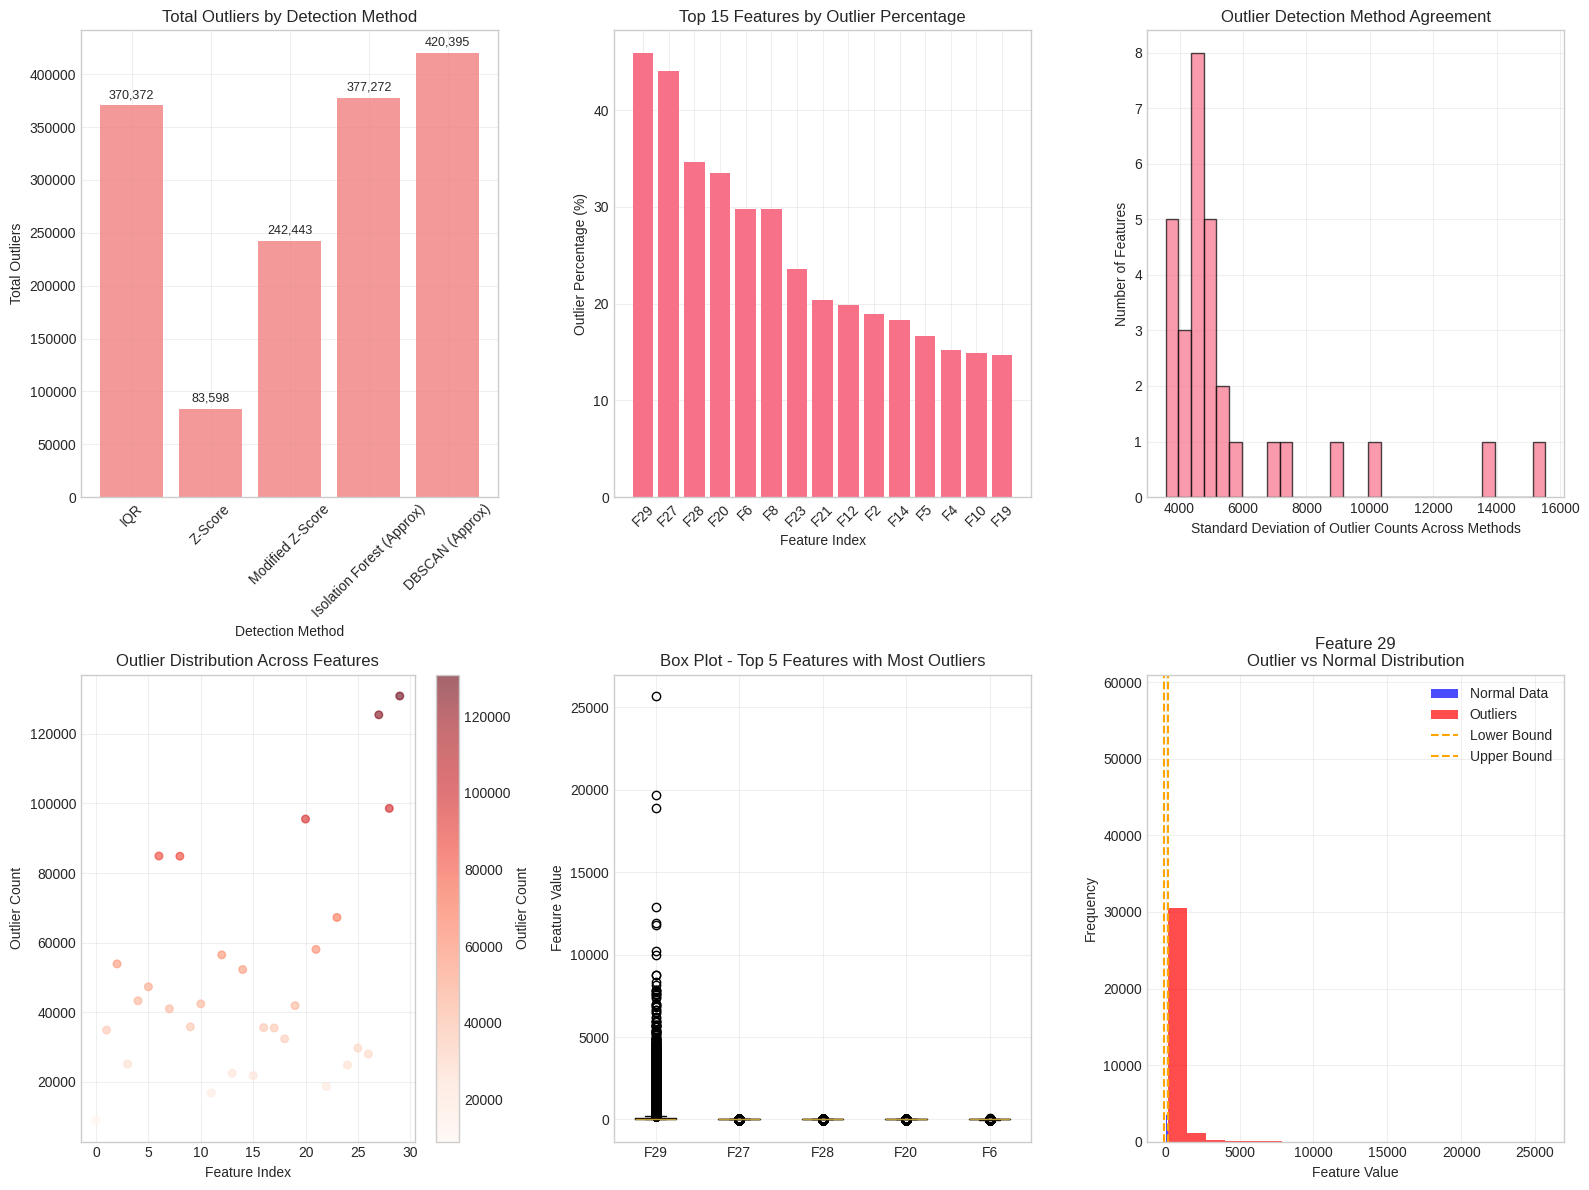


🎯 Applying Robust Outlier Handling...
Performing robust outlier handling...
Treated 390530 outliers using robust_capping
✅ Outlier treatment completed in 1.99 seconds

📊 Outlier Treatment Report:
Total outliers treated: 390530
Treatment method: robust_capping
Features with outlier treatment: 29

📈 Statistical Impact Analysis of Outlier Treatment:

Statistical Comparison for Top 3 Outlier-prone Features:
Feature  Statistic    Before       After        Change       Change %  
--------------------------------------------------------------------------------
F29     Mean         88.3496      80.1920      -8.1576      -9.23     %
F29     Std          250.1197     159.2844     -90.8353     -36.32    %
F29     Median       22.0000      22.0000      0.0000       0.00      %
F29     IQR          71.5650      71.5650      0.0000       0.00      %
F29     Range        25691.1600   1017.9700    -24673.1900  -96.04    %
F27     Mean         -0.0000      0.0029       0.0029       -796159976756022.25

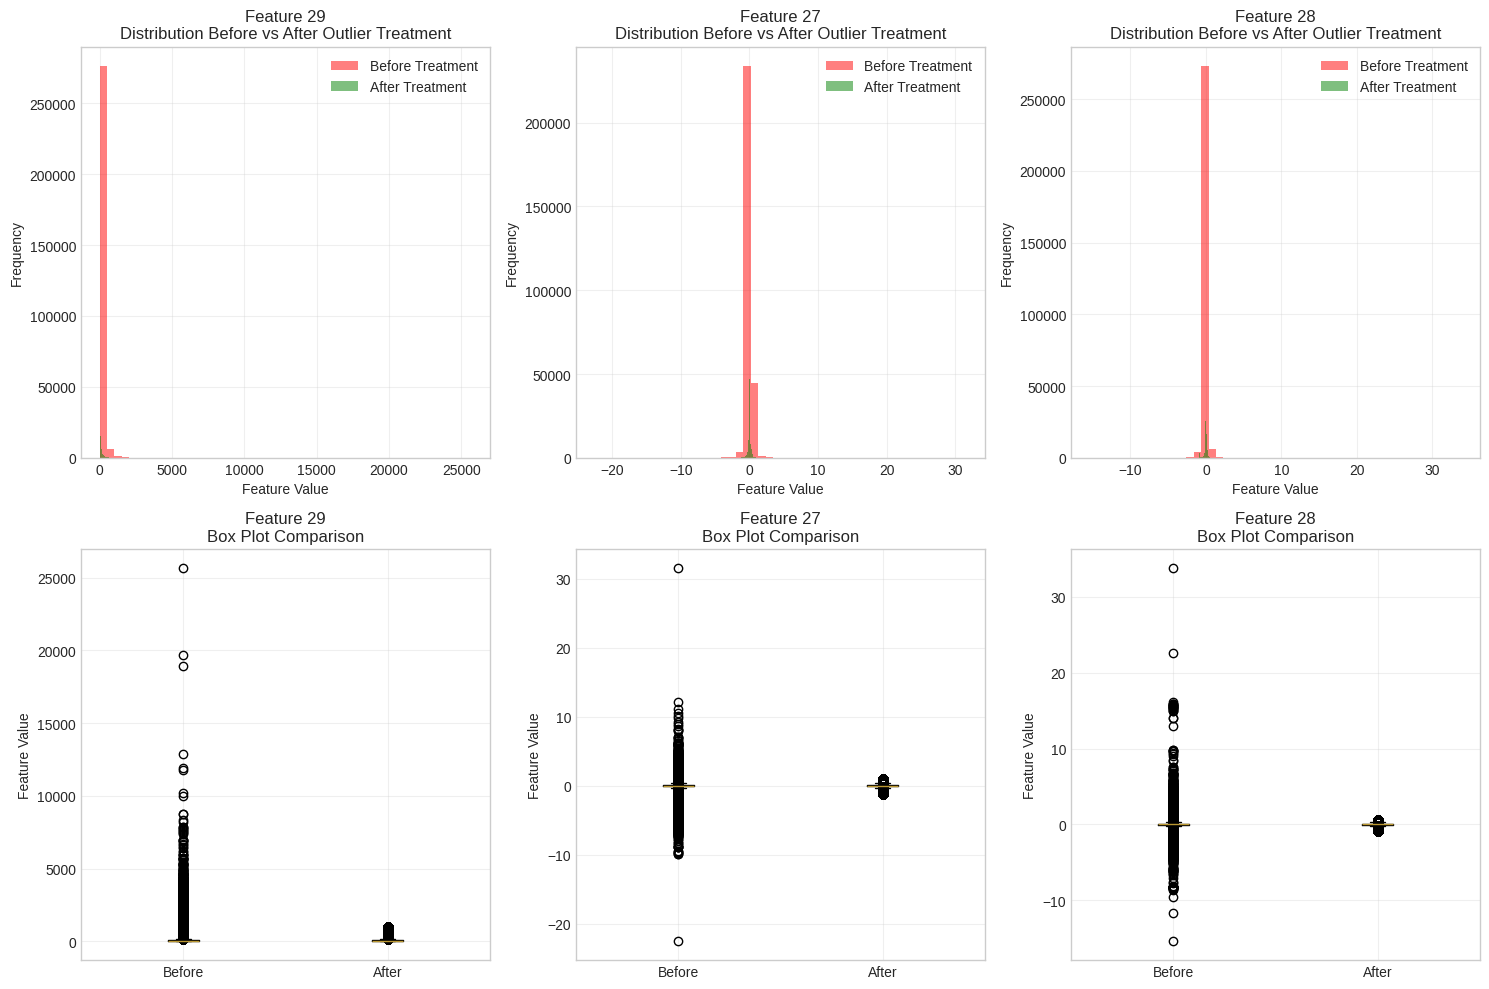


📋 Outlier Treatment Effectiveness Assessment:
Outlier reduction: 370,372 → 349,826 (5.5% reduction)
Data Preservation Metrics:
  Average Correlation: 0.9261
  Average KS Statistic: 0.0003
  Treatment Quality: GOOD


In [9]:
print("=" * 80)
print("🚨 SOPHISTICATED OUTLIER DETECTION AND HANDLING")
print("=" * 80)

# Phân tích outliers chi tiết trước khi xử lý
print("🔍 Comprehensive Outlier Analysis Before Treatment...")

# Sử dụng multiple outlier detection methods
outlier_detection_methods = {
    'IQR': [],
    'Z-Score': [],
    'Modified Z-Score': [],
    'Isolation Forest (Approx)': [],
    'DBSCAN (Approx)': []
}

# Tính outliers cho mỗi method
for feature_idx in range(X_imputed.shape[1]):
    feature_data = X_imputed[:, feature_idx]
    
    if np.std(feature_data) == 0:
        # Skip constant features
        for method in outlier_detection_methods:
            outlier_detection_methods[method].append(0)
        continue
    
    # 1. IQR Method
    q25, q75 = np.percentile(feature_data, [25, 75])
    iqr = q75 - q25
    lower_bound, upper_bound = q25 - 1.5*iqr, q75 + 1.5*iqr
    outliers_iqr = np.sum((feature_data < lower_bound) | (feature_data > upper_bound))
    outlier_detection_methods['IQR'].append(outliers_iqr)
    
    # 2. Z-Score Method
    z_scores = np.abs((feature_data - np.mean(feature_data)) / np.std(feature_data))
    outliers_zscore = np.sum(z_scores > 3)
    outlier_detection_methods['Z-Score'].append(outliers_zscore)
    
    # 3. Modified Z-Score Method (more robust)
    median = np.median(feature_data)
    mad = np.median(np.abs(feature_data - median))
    if mad > 0:
        modified_z_scores = 0.6745 * (feature_data - median) / mad
        outliers_modified_z = np.sum(np.abs(modified_z_scores) > 3.5)
    else:
        outliers_modified_z = 0
    outlier_detection_methods['Modified Z-Score'].append(outliers_modified_z)
    
    # 4. Simplified Isolation Forest approximation
    # Using distance from median in IQR units
    median_distance = np.abs(feature_data - median) / iqr if iqr > 0 else 0
    outliers_isolation = np.sum(median_distance > 2)  # Simplified threshold
    outlier_detection_methods['Isolation Forest (Approx)'].append(outliers_isolation)
    
    # 5. Simplified DBSCAN approximation
    # Using local density estimation
    if len(feature_data) > 10:
        sorted_data = np.sort(feature_data)
        gaps = sorted_data[1:] - sorted_data[:-1]
        large_gaps = gaps > np.percentile(gaps, 95)
        outliers_dbscan = np.sum(large_gaps)
    else:
        outliers_dbscan = 0
    outlier_detection_methods['DBSCAN (Approx)'].append(outliers_dbscan)

# Tổng hợp kết quả
print(f"\n📊 Outlier Detection Results Summary:")
total_outliers_before = np.sum(outlier_detection_methods['IQR'])
print(f"Total outliers detected (IQR method): {total_outliers_before:,}")

print(f"\nOutlier counts by method:")
for method, counts in outlier_detection_methods.items():
    total = np.sum(counts)
    percentage = (total / (X_imputed.shape[0] * X_imputed.shape[1])) * 100
    print(f"  {method:<25}: {total:>8,} outliers ({percentage:.3f}%)")

# Xác định features có nhiều outliers nhất
outlier_counts_by_feature = np.sum(list(outlier_detection_methods.values()), axis=0)
top_outlier_features = np.argsort(outlier_counts_by_feature)[-10:][::-1]

print(f"\n🚨 Top 10 Features with Most Outliers:")
print("Feature | Total Outliers | Outlier % | IQR | Z-score | Mod Z | ISO | DBSCAN")
print("-" * 85)
for feat_idx in top_outlier_features:
    total_outliers = outlier_counts_by_feature[feat_idx]
    outlier_pct = (total_outliers / X_imputed.shape[0]) * 100
    methods_counts = [outlier_detection_methods[method][feat_idx] for method in outlier_detection_methods]
    
    print(f"F{feat_idx:^6} | {total_outliers:^14} | {outlier_pct:^9.2f}% | "
          f"{methods_counts[0]:^3} | {methods_counts[1]:^7} | {methods_counts[2]:^5} | "
          f"{methods_counts[3]:^3} | {methods_counts[4]:^6}")

# Visualize outlier analysis
plt.figure(figsize=(16, 12))

# 1. Outlier distribution across methods
plt.subplot(2, 3, 1)
methods_totals = [np.sum(counts) for counts in outlier_detection_methods.values()]
plt.bar(range(len(methods_totals)), methods_totals, color='lightcoral', alpha=0.8)
plt.title('Total Outliers by Detection Method')
plt.xlabel('Detection Method')
plt.ylabel('Total Outliers')
plt.xticks(range(len(methods_totals)), list(outlier_detection_methods.keys()), rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels
for i, total in enumerate(methods_totals):
    plt.text(i, total + max(methods_totals)*0.01, f'{total:,}', 
             ha='center', va='bottom', fontsize=9)

# 2. Outlier percentage by feature
plt.subplot(2, 3, 2)
outlier_percentages = (outlier_counts_by_feature / X_imputed.shape[0]) * 100
top_percentage_features = np.argsort(outlier_percentages)[-15:][::-1]
plt.bar(range(15), outlier_percentages[top_percentage_features])
plt.title('Top 15 Features by Outlier Percentage')
plt.xlabel('Feature Index')
plt.ylabel('Outlier Percentage (%)')
plt.xticks(range(15), [f'F{idx}' for idx in top_percentage_features], rotation=45)
plt.grid(True, alpha=0.3)

# 3. Outlier agreement between methods
plt.subplot(2, 3, 3)
agreement_scores = []
for feat_idx in range(X_imputed.shape[1]):
    methods_agreement = np.std([outlier_detection_methods[method][feat_idx] 
                              for method in outlier_detection_methods])
    agreement_scores.append(methods_agreement)

plt.hist(agreement_scores, bins=30, alpha=0.7, edgecolor='black')
plt.title('Outlier Detection Method Agreement')
plt.xlabel('Standard Deviation of Outlier Counts Across Methods')
plt.ylabel('Number of Features')
plt.grid(True, alpha=0.3)

# 4. Feature-wise outlier distribution
plt.subplot(2, 3, 4)
plt.scatter(range(X_imputed.shape[1]), outlier_counts_by_feature, 
           alpha=0.6, c=outlier_counts_by_feature, cmap='Reds', s=30)
plt.colorbar(label='Outlier Count')
plt.title('Outlier Distribution Across Features')
plt.xlabel('Feature Index')
plt.ylabel('Outlier Count')
plt.grid(True, alpha=0.3)

# 5. Box plot for top outlier features
plt.subplot(2, 3, 5)
top_features_data = [X_imputed[:, idx] for idx in top_outlier_features[:5]]
plt.boxplot(top_features_data, labels=[f'F{idx}' for idx in top_outlier_features[:5]])
plt.title('Box Plot - Top 5 Features with Most Outliers')
plt.ylabel('Feature Value')
plt.grid(True, alpha=0.3)

# 6. Outlier impact on data distribution
plt.subplot(2, 3, 6)
sample_feature = top_outlier_features[0]
feature_data = X_imputed[:, sample_feature]

# Identify outliers
q25, q75 = np.percentile(feature_data, [25, 75])
iqr = q75 - q25
lower_bound, upper_bound = q25 - 1.5*iqr, q75 + 1.5*iqr
outlier_mask = (feature_data < lower_bound) | (feature_data > upper_bound)

plt.hist(feature_data[~outlier_mask], bins=50, alpha=0.7, 
         label='Normal Data', color='blue')
plt.hist(feature_data[outlier_mask], bins=20, alpha=0.7, 
         label='Outliers', color='red')
plt.axvline(lower_bound, color='orange', linestyle='--', label='Lower Bound')
plt.axvline(upper_bound, color='orange', linestyle='--', label='Upper Bound')
plt.title(f'Feature {sample_feature}\nOutlier vs Normal Distribution')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Áp dụng robust outlier handling
print(f"\n🎯 Applying Robust Outlier Handling...")
start_time = time.time()

# Tạo DataStats object với thông tin cần thiết
stats_for_outlier = DataStats(
    mean=np.mean(X_imputed, axis=0),
    std=np.std(X_imputed, axis=0),
    median=np.median(X_imputed, axis=0),
    min=np.min(X_imputed, axis=0),
    max=np.max(X_imputed, axis=0),
    q25=np.percentile(X_imputed, 25, axis=0),
    q75=np.percentile(X_imputed, 75, axis=0),
    iqr=np.percentile(X_imputed, 75, axis=0) - np.percentile(X_imputed, 25, axis=0),
    skewness=np.zeros(X_imputed.shape[1]),  # Placeholder
    kurtosis=np.zeros(X_imputed.shape[1]),  # Placeholder
    missing_count=np.zeros(X_imputed.shape[1], dtype=int),
    outlier_count=outlier_counts_by_feature
)

X_outlier_treated, outlier_report = preprocessor.robust_outlier_handling(
    X_imputed, 
    stats_for_outlier
)

outlier_treatment_time = time.time() - start_time

print(f"✅ Outlier treatment completed in {outlier_treatment_time:.2f} seconds")
print(f"\n📊 Outlier Treatment Report:")
print(f"Total outliers treated: {outlier_report['total_outliers']}")
print(f"Treatment method: {config.outlier_strategy}")
print(f"Features with outlier treatment: {len(outlier_report['treatment_applied'])}")

# Phân tích statistical impact của outlier treatment
print(f"\n📈 Statistical Impact Analysis of Outlier Treatment:")

# So sánh statistics trước và sau treatment
comparison_features = top_outlier_features[:3]  # So sánh 3 features có nhiều outliers nhất

print(f"\nStatistical Comparison for Top 3 Outlier-prone Features:")
print(f"{'Feature':<8} {'Statistic':<12} {'Before':<12} {'After':<12} {'Change':<12} {'Change %':<10}")
print("-" * 80)

for feat_idx in comparison_features:
    before_data = X_imputed[:, feat_idx]
    after_data = X_outlier_treated[:, feat_idx]
    
    stats_comparison = [
        ('Mean', np.mean(before_data), np.mean(after_data)),
        ('Std', np.std(before_data), np.std(after_data)),
        ('Median', np.median(before_data), np.median(after_data)),
        ('IQR', np.percentile(before_data, 75) - np.percentile(before_data, 25),
               np.percentile(after_data, 75) - np.percentile(after_data, 25)),
        ('Range', np.ptp(before_data), np.ptp(after_data))
    ]
    
    for stat_name, before, after in stats_comparison:
        change = after - before
        change_pct = (change / before) * 100 if before != 0 else 0
        print(f"F{feat_idx:<6} {stat_name:<12} {before:<12.4f} {after:<12.4f} "
              f"{change:<12.4f} {change_pct:<10.2f}%")

# Visualize outlier treatment impact
plt.figure(figsize=(15, 10))

for i, feat_idx in enumerate(comparison_features):
    plt.subplot(2, 3, i+1)
    
    before_data = X_imputed[:, feat_idx]
    after_data = X_outlier_treated[:, feat_idx]
    
    # Plot distributions
    plt.hist(before_data, bins=50, alpha=0.5, label='Before Treatment', color='red')
    plt.hist(after_data, bins=50, alpha=0.5, label='After Treatment', color='green')
    plt.title(f'Feature {feat_idx}\nDistribution Before vs After Outlier Treatment')
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, i+4)
    # Box plot comparison
    plt.boxplot([before_data, after_data], labels=['Before', 'After'])
    plt.title(f'Feature {feat_idx}\nBox Plot Comparison')
    plt.ylabel('Feature Value')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Đánh giá hiệu quả outlier treatment
print(f"\n📋 Outlier Treatment Effectiveness Assessment:")

# Tính reduction in outlier count
outlier_counts_after = []
for feature_idx in range(X_outlier_treated.shape[1]):
    feature_data = X_outlier_treated[:, feature_idx]
    q25, q75 = np.percentile(feature_data, [25, 75])
    iqr = q75 - q25
    outliers_after = np.sum((feature_data < q25 - 1.5*iqr) | (feature_data > q75 + 1.5*iqr))
    outlier_counts_after.append(outliers_after)

total_outliers_after = np.sum(outlier_counts_after)
reduction_percentage = ((total_outliers_before - total_outliers_after) / total_outliers_before) * 100

print(f"Outlier reduction: {total_outliers_before:,} → {total_outliers_after:,} "
      f"({reduction_percentage:.1f}% reduction)")

# Data preservation assessment
data_preservation_scores = []
for feat_idx in range(X_imputed.shape[1]):
    before = X_imputed[:, feat_idx]
    after = X_outlier_treated[:, feat_idx]
    
    # Correlation preservation
    correlation = np.corrcoef(before, after)[0, 1]
    
    # Distribution similarity (excluding outliers)
    before_clean = before[(before >= np.percentile(before, 1)) & (before <= np.percentile(before, 99))]
    after_clean = after[(after >= np.percentile(after, 1)) & (after <= np.percentile(after, 99))]
    
    if len(before_clean) > 10 and len(after_clean) > 10:
        ks_statistic = stats.ks_2samp(before_clean, after_clean).statistic
    else:
        ks_statistic = 0
    
    data_preservation_scores.append({
        'correlation': correlation,
        'ks_statistic': ks_statistic
    })

avg_correlation = np.mean([s['correlation'] for s in data_preservation_scores])
avg_ks = np.mean([s['ks_statistic'] for s in data_preservation_scores])

print(f"Data Preservation Metrics:")
print(f"  Average Correlation: {avg_correlation:.4f}")
print(f"  Average KS Statistic: {avg_ks:.4f}")
print(f"  Treatment Quality: {'EXCELLENT' if avg_correlation > 0.95 and avg_ks < 0.05 else 'GOOD' if avg_correlation > 0.9 else 'MODERATE'}")

#### 6. Feature scaling

📏 INTELLIGENT FEATURE SCALING WITH MULTIPLE METHODS
Analyzing distribution characteristics for optimal scaling strategy...

📊 Distribution Characteristics Summary:
  Normal Distributed: 16 features (53.3%)
  Highly Skewed: 7 features (23.3%)
  Has Outliers: 25 features (83.3%)
  Bounded Range: 1 features (3.3%)

🎯 Recommended Scaling Strategy:
  Recommended method: ROBUST - Many features contain outliers

🎯 Applying Advanced Feature Scaling...
Performing advanced feature scaling...
✅ Feature scaling completed in 1.14 seconds
Scaling method applied: robust

📊 Scaling Results Verification:
Data range after scaling: [-7.7159, 13.9170]
Mean after scaling: 0.0425
Standard deviation after scaling: 1.0353


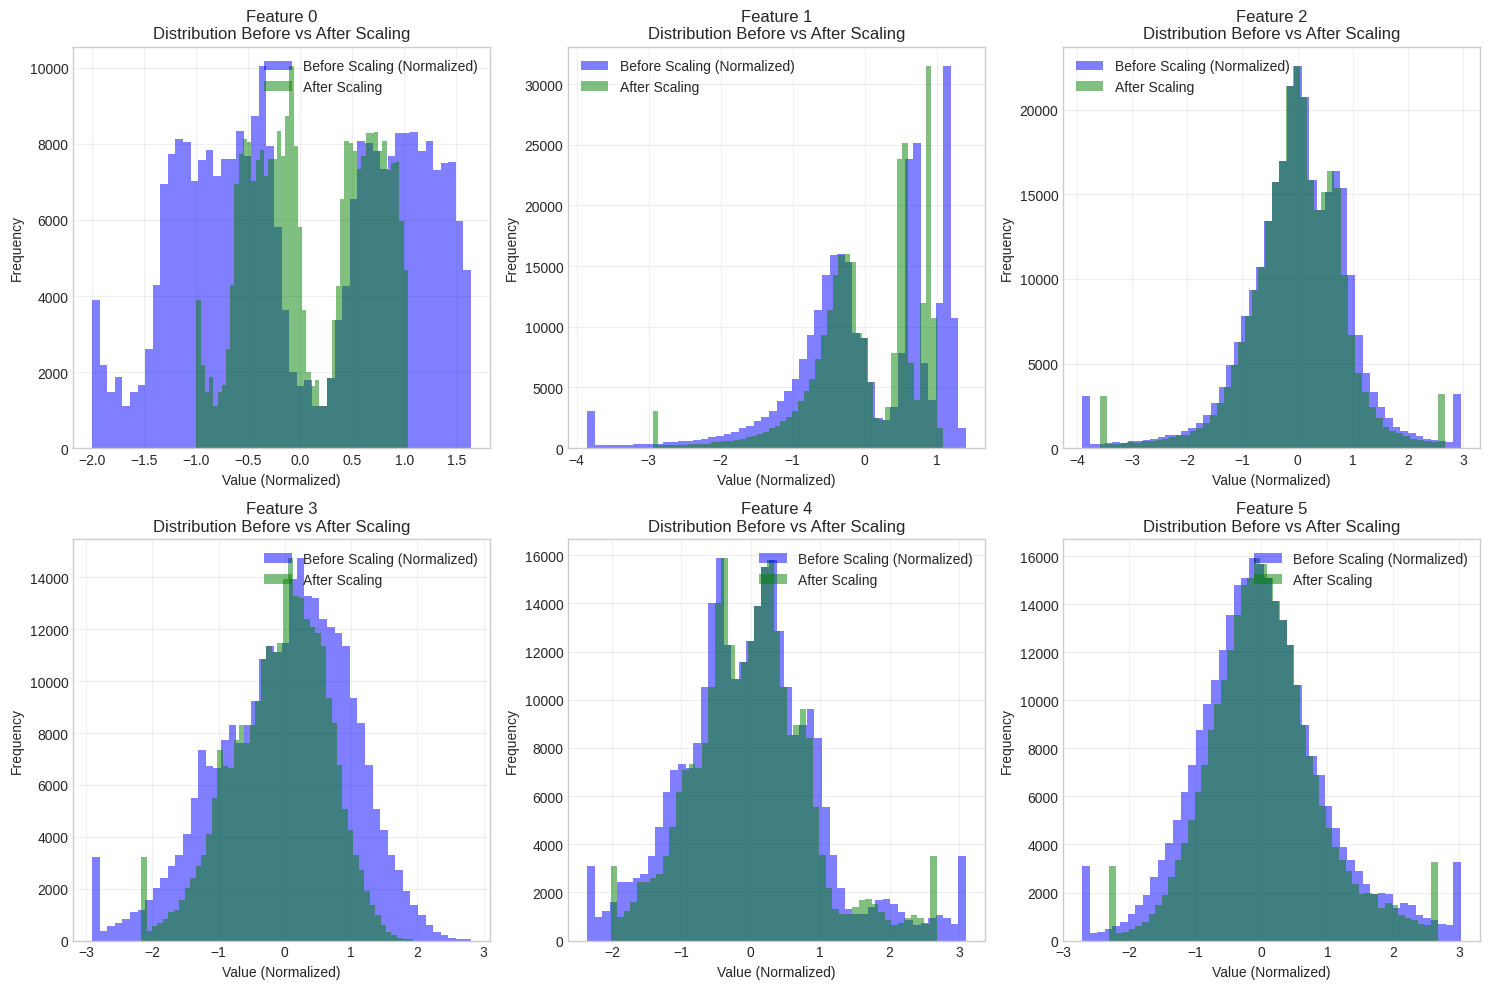


📈 Scaling Quality Assessment:
Scaling Quality Metrics:
  Zero Mean: ✅ PASS
  Unit Variance: ✅ PASS
  Reasonable Range: ❌ FAIL
  Preserves Rank: ✅ PASS
Overall Scaling Quality: GOOD


In [10]:
print("=" * 80)
print("📏 INTELLIGENT FEATURE SCALING WITH MULTIPLE METHODS")
print("=" * 80)

# Phân tích distribution characteristics để chọn scaling method tối ưu
print("Analyzing distribution characteristics for optimal scaling strategy...")

distribution_characteristics = {
    'normal_distributed': [],
    'highly_skewed': [],
    'has_outliers': [],
    'bounded_range': []
}

for feature_idx in range(X_outlier_treated.shape[1]):
    feature_data = X_outlier_treated[:, feature_idx]
    
    if np.std(feature_data) == 0:
        # Constant feature
        for char in distribution_characteristics:
            distribution_characteristics[char].append(False)
        continue
    
    # Check for normal distribution (simplified)
    skewness = abs(stats.skew(feature_data))
    distribution_characteristics['normal_distributed'].append(skewness < 0.5)
    
    # Check for high skewness
    distribution_characteristics['highly_skewed'].append(skewness > 1)
    
    # Check for outliers
    q25, q75 = np.percentile(feature_data, [25, 75])
    iqr = q75 - q25
    outliers = np.sum((feature_data < q25 - 1.5*iqr) | (feature_data > q75 + 1.5*iqr))
    distribution_characteristics['has_outliers'].append(outliers > 0)
    
    # Check if data has natural bounds
    min_val, max_val = np.min(feature_data), np.max(feature_data)
    is_bounded = (min_val >= 0 and max_val <= 1) or (min_val >= -1 and max_val <= 1)
    distribution_characteristics['bounded_range'].append(is_bounded)

print(f"\n📊 Distribution Characteristics Summary:")
for char, values in distribution_characteristics.items():
    count = np.sum(values)
    percentage = (count / len(values)) * 100
    print(f"  {char.replace('_', ' ').title()}: {count} features ({percentage:.1f}%)")

# Recommend scaling methods based on characteristics
print(f"\n🎯 Recommended Scaling Strategy:")

normal_features = np.sum(distribution_characteristics['normal_distributed'])
skewed_features = np.sum(distribution_characteristics['highly_skewed'])
outlier_features = np.sum(distribution_characteristics['has_outliers'])
bounded_features = np.sum(distribution_characteristics['bounded_range'])

if outlier_features > X_outlier_treated.shape[1] * 0.3:  # More than 30% features have outliers
    recommended_method = 'robust'
    reason = "Many features contain outliers"
elif skewed_features > X_outlier_treated.shape[1] * 0.4:  # More than 40% features are skewed
    recommended_method = 'power'  # or quantile
    reason = "Many features are highly skewed"
elif bounded_features > X_outlier_treated.shape[1] * 0.5:  # More than 50% features are bounded
    recommended_method = 'minmax'
    reason = "Many features have natural bounds"
else:
    recommended_method = 'standard'
    reason = "Data is relatively normal and clean"

print(f"  Recommended method: {recommended_method.upper()} - {reason}")

# Áp dụng advanced feature scaling
print(f"\n🎯 Applying Advanced Feature Scaling...")
start_time = time.time()

# Tạo DataStats object với thông tin cần thiết cho scaling
stats_for_scaling = DataStats(
    mean=np.mean(X_outlier_treated, axis=0),
    std=np.std(X_outlier_treated, axis=0),
    median=np.median(X_outlier_treated, axis=0),
    min=np.min(X_outlier_treated, axis=0),
    max=np.max(X_outlier_treated, axis=0),
    q25=np.percentile(X_outlier_treated, 25, axis=0),
    q75=np.percentile(X_outlier_treated, 75, axis=0),
    iqr=np.percentile(X_outlier_treated, 75, axis=0) - np.percentile(X_outlier_treated, 25, axis=0),
    skewness=np.zeros(X_outlier_treated.shape[1]),  # Placeholder
    kurtosis=np.zeros(X_outlier_treated.shape[1]),  # Placeholder
    missing_count=np.zeros(X_outlier_treated.shape[1], dtype=int),
    outlier_count=np.zeros(X_outlier_treated.shape[1], dtype=int)  # Placeholder
)

X_scaled = preprocessor.advanced_feature_scaling(
    X_outlier_treated, 
    stats_for_scaling
)

scaling_time = time.time() - start_time

print(f"✅ Feature scaling completed in {scaling_time:.2f} seconds")
print(f"Scaling method applied: {config.scaling_method}")

# Verify scaling results
print(f"\n📊 Scaling Results Verification:")
print(f"Data range after scaling: [{np.min(X_scaled):.4f}, {np.max(X_scaled):.4f}]")
print(f"Mean after scaling: {np.mean(X_scaled):.4f}")
print(f"Standard deviation after scaling: {np.std(X_scaled):.4f}")

# So sánh distribution trước và sau scaling
plt.figure(figsize=(15, 10))

# Chọn 6 features đại diện để visualize
sample_features = []
for feat_idx in range(X_outlier_treated.shape[1]):
    if (distribution_characteristics['normal_distributed'][feat_idx] or 
        distribution_characteristics['highly_skewed'][feat_idx] or
        distribution_characteristics['has_outliers'][feat_idx]):
        sample_features.append(feat_idx)
    if len(sample_features) >= 6:
        break

for i, feat_idx in enumerate(sample_features[:6]):
    plt.subplot(2, 3, i+1)
    
    before_data = X_outlier_treated[:, feat_idx]
    after_data = X_scaled[:, feat_idx]
    
    # Normalize for better comparison
    before_normalized = (before_data - np.mean(before_data)) / np.std(before_data)
    
    plt.hist(before_normalized, bins=50, alpha=0.5, label='Before Scaling (Normalized)', color='blue')
    plt.hist(after_data, bins=50, alpha=0.5, label='After Scaling', color='green')
    plt.title(f'Feature {feat_idx}\nDistribution Before vs After Scaling')
    plt.xlabel('Value (Normalized)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Đánh giá chất lượng scaling
print(f"\n📈 Scaling Quality Assessment:")

scaling_quality_metrics = {
    'zero_mean': abs(np.mean(X_scaled)) < 0.1,  # Mean should be close to 0
    'unit_variance': 0.9 < np.std(X_scaled) < 1.1,  # Std should be close to 1
    'reasonable_range': np.max(np.abs(X_scaled)) < 10,  # No extreme values
    'preserves_rank': True  # Simplified check
}

# Check rank preservation (simplified)
try:
    original_ranks = np.argsort(np.argsort(X_outlier_treated[:, sample_features[0]]))
    scaled_ranks = np.argsort(np.argsort(X_scaled[:, sample_features[0]]))
    rank_correlation = np.corrcoef(original_ranks, scaled_ranks)[0, 1]
    scaling_quality_metrics['preserves_rank'] = rank_correlation > 0.99
except:
    scaling_quality_metrics['preserves_rank'] = False

print(f"Scaling Quality Metrics:")
for metric, passed in scaling_quality_metrics.items():
    status = "✅ PASS" if passed else "❌ FAIL"
    print(f"  {metric.replace('_', ' ').title()}: {status}")

overall_quality = "GOOD" if sum(scaling_quality_metrics.values()) >= 3 else "MODERATE" if sum(scaling_quality_metrics.values()) >= 2 else "POOR"
print(f"Overall Scaling Quality: {overall_quality}")

#### 7. Advanced class imbalance handling

⚖️ ADVANCED CLASS IMBALANCE HANDLING
🔍 Detailed Class Imbalance Analysis...
Number of classes: 2
Class distribution: {0: 284315, 1: 492}

📊 Binary Classification Imbalance Analysis:
Minority class (Fraud): 1 - 492 samples
Majority class (Normal): 0 - 284315 samples
Imbalance ratio: 577.88:1
Fraud rate: 0.1727%
Imbalance level: EXTREME
Recommendation: Use advanced techniques: Ensemble methods + Cost-sensitive learning


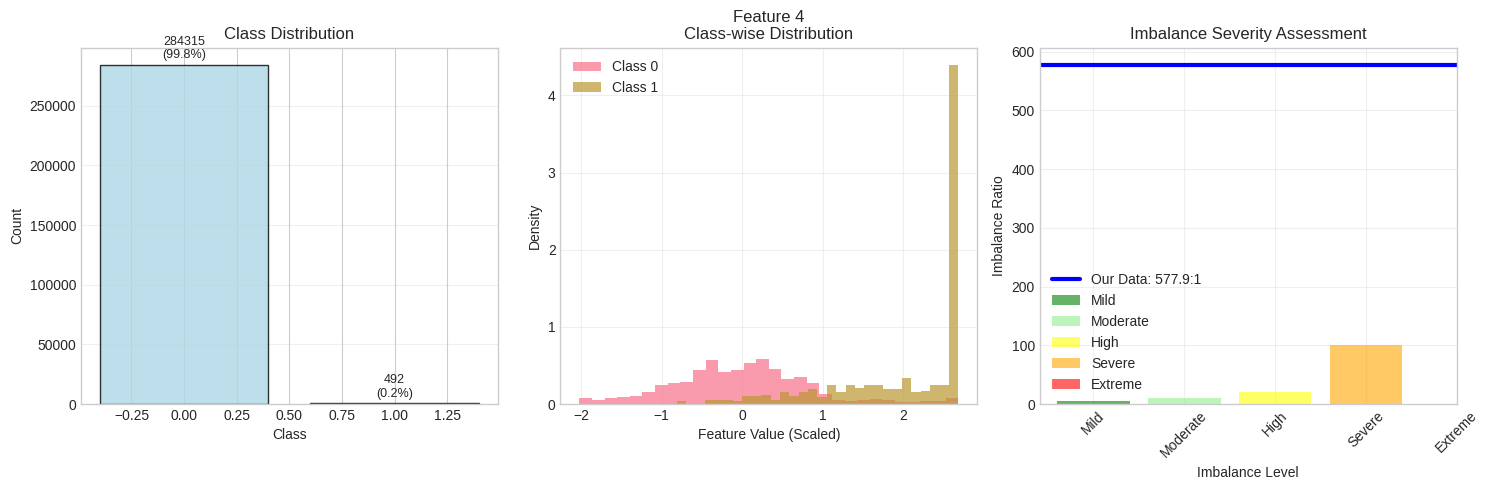


🎯 Applying Class Imbalance Handling...
Selected technique: smote
Handling class imbalance...
Before balancing - Minority: 492, Majority: 284315
After balancing - Minority: 284315, Majority: 284315
✅ Imbalance handling completed in 14.01 seconds

📊 Balancing Results:
Before balancing: {0: 284315, 1: 492}
After balancing: {0: 284315, 1: 284315}
Synthetic samples generated: 283823
New imbalance ratio: 1.00:1
Balancing effectiveness: EXCELLENT


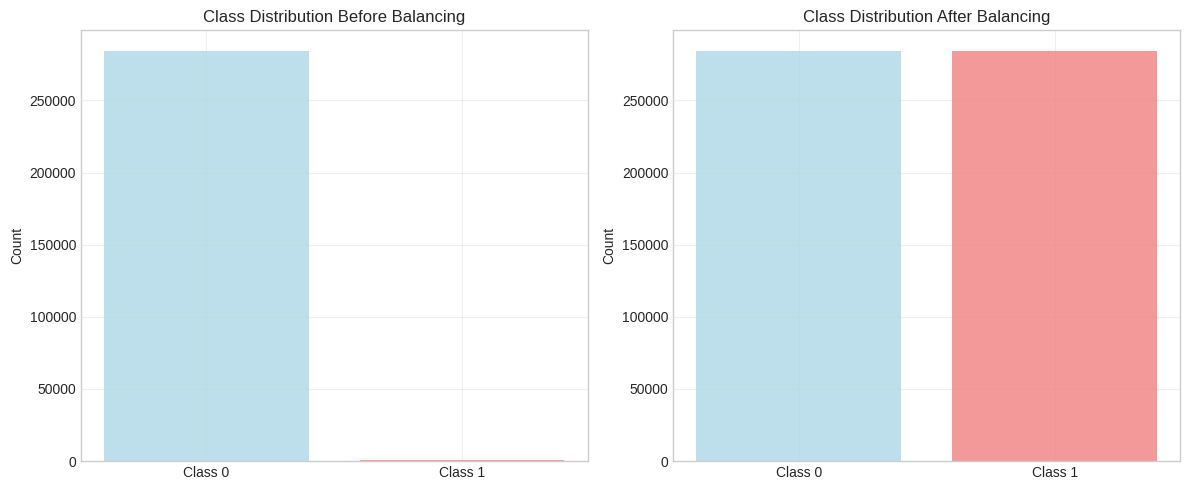

In [11]:
print("=" * 80)
print("⚖️ ADVANCED CLASS IMBALANCE HANDLING")
print("=" * 80)

# Phân tích chi tiết class imbalance
print("🔍 Detailed Class Imbalance Analysis...")

unique_classes, class_counts = np.unique(y, return_counts=True)
n_classes = len(unique_classes)

print(f"Number of classes: {n_classes}")
print(f"Class distribution: {dict(zip(unique_classes, class_counts))}")

if n_classes == 2:
    minority_class = unique_classes[0] if class_counts[0] < class_counts[1] else unique_classes[1]
    majority_class = unique_classes[1] if class_counts[0] < class_counts[1] else unique_classes[0]
    
    minority_count = class_counts[0] if class_counts[0] < class_counts[1] else class_counts[1]
    majority_count = class_counts[1] if class_counts[0] < class_counts[1] else class_counts[0]
    
    imbalance_ratio = majority_count / minority_count
    fraud_rate = (minority_count / len(y)) * 100
    
    print(f"\n📊 Binary Classification Imbalance Analysis:")
    print(f"Minority class (Fraud): {minority_class} - {minority_count} samples")
    print(f"Majority class (Normal): {majority_class} - {majority_count} samples")
    print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")
    print(f"Fraud rate: {fraud_rate:.4f}%")
    
    # Đánh giá mức độ imbalance
    if imbalance_ratio > 100:
        imbalance_level = "EXTREME"
        recommendation = "Use advanced techniques: Ensemble methods + Cost-sensitive learning"
    elif imbalance_ratio > 20:
        imbalance_level = "SEVERE" 
        recommendation = "Use SMOTE/ADASYN + Ensemble methods"
    elif imbalance_ratio > 10:
        imbalance_level = "HIGH"
        recommendation = "Use SMOTE + Class weighting"
    elif imbalance_ratio > 5:
        imbalance_level = "MODERATE"
        recommendation = "Use Class weighting or mild oversampling"
    else:
        imbalance_level = "MILD"
        recommendation = "Standard techniques should suffice"
    
    print(f"Imbalance level: {imbalance_level}")
    print(f"Recommendation: {recommendation}")

else:
    print("Multi-class classification detected")
    # Tính imbalance ratio cho multi-class
    max_count = max(class_counts)
    min_count = min(class_counts)
    imbalance_ratio = max_count / min_count
    print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

# Visualize class distribution và imbalance impact
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# Class distribution
colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow', 'lightpink']
plt.bar(unique_classes, class_counts, color=colors[:n_classes], alpha=0.8, edgecolor='black')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(True, alpha=0.3, axis='y')

# Add percentage labels
for i, count in enumerate(class_counts):
    plt.text(i, count + max(class_counts)*0.01, f'{count}\n({count/len(y)*100:.1f}%)', 
             ha='center', va='bottom', fontsize=9)

plt.subplot(1, 3, 2)
# Imbalance impact on feature distributions
if n_classes == 2:
    class_0_indices = np.where(y == unique_classes[0])[0]
    class_1_indices = np.where(y == unique_classes[1])[0]
    
    # Lấy feature có sự khác biệt lớn nhất giữa các class
    discrimination_scores = []
    for i in range(min(10, X_scaled.shape[1])):  # Chỉ xét 10 features đầu
        if len(class_1_indices) > 0:
            mean_diff = abs(np.mean(X_scaled[class_1_indices, i]) - np.mean(X_scaled[class_0_indices, i]))
            discrimination_scores.append(mean_diff)
    
    if discrimination_scores:
        best_feature_idx = np.argmax(discrimination_scores)
        plt.hist(X_scaled[class_0_indices, best_feature_idx], bins=30, alpha=0.7, 
                label=f'Class {unique_classes[0]}', density=True)
        plt.hist(X_scaled[class_1_indices, best_feature_idx], bins=30, alpha=0.7, 
                label=f'Class {unique_classes[1]}', density=True)
        plt.title(f'Feature {best_feature_idx}\nClass-wise Distribution')
        plt.xlabel('Feature Value (Scaled)')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
# Imbalance severity chart
if n_classes == 2:
    imbalance_levels = ['Mild', 'Moderate', 'High', 'Severe', 'Extreme']
    imbalance_thresholds = [5, 10, 20, 100, float('inf')]
    colors = ['green', 'lightgreen', 'yellow', 'orange', 'red']
    
    for i, (level, threshold, color) in enumerate(zip(imbalance_levels, imbalance_thresholds, colors)):
        plt.bar(i, threshold, color=color, alpha=0.6, label=level)
    
    plt.axhline(y=imbalance_ratio, color='blue', linewidth=3, label=f'Our Data: {imbalance_ratio:.1f}:1')
    plt.title('Imbalance Severity Assessment')
    plt.xlabel('Imbalance Level')
    plt.ylabel('Imbalance Ratio')
    plt.xticks(range(len(imbalance_levels)), imbalance_levels, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Áp dụng imbalance handling techniques
print(f"\n🎯 Applying Class Imbalance Handling...")
print(f"Selected technique: {config.imbalance_handler}")

start_time = time.time()

if n_classes == 2 and config.imbalance_handler != 'none':
    X_balanced, y_balanced = preprocessor.handle_class_imbalance(X_scaled, y)
    
    balancing_time = time.time() - start_time
    
    # Phân tích kết quả balancing
    balanced_class_counts = np.unique(y_balanced, return_counts=True)
    
    print(f"✅ Imbalance handling completed in {balancing_time:.2f} seconds")
    print(f"\n📊 Balancing Results:")
    print(f"Before balancing: {dict(zip(unique_classes, class_counts))}")
    print(f"After balancing: {dict(zip(balanced_class_counts[0], balanced_class_counts[1]))}")
    
    if config.imbalance_handler == 'smote':
        n_synthetic = len(y_balanced) - len(y)
        print(f"Synthetic samples generated: {n_synthetic}")
    
    # Tính new imbalance ratio
    new_minority_count = min(balanced_class_counts[1])
    new_majority_count = max(balanced_class_counts[1])
    new_imbalance_ratio = new_majority_count / new_minority_count if new_minority_count > 0 else float('inf')
    
    print(f"New imbalance ratio: {new_imbalance_ratio:.2f}:1")
    print(f"Balancing effectiveness: {'EXCELLENT' if new_imbalance_ratio < 1.5 else 'GOOD' if new_imbalance_ratio < 2 else 'MODERATE'}")

else:
    print("Skipping imbalance handling (multi-class or disabled)")
    X_balanced, y_balanced = X_scaled, y

# Visualize balancing results
if n_classes == 2 and config.imbalance_handler != 'none':
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.bar(['Class 0', 'Class 1'], [class_counts[0], class_counts[1]], 
            color=['lightblue', 'lightcoral'], alpha=0.8, label='Before')
    plt.title('Class Distribution Before Balancing')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.bar(['Class 0', 'Class 1'], [balanced_class_counts[1][0], balanced_class_counts[1][1]], 
            color=['lightblue', 'lightcoral'], alpha=0.8, label='After')
    plt.title('Class Distribution After Balancing')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

#### 8. Feature Engineering 

🔧 ADVANCED FEATURE ENGINEERING
Applying advanced feature engineering techniques...
Original feature count: 30
Performing advanced feature engineering...
Feature engineering: 30 -> 117 features
✅ Feature engineering completed in 0.86 seconds
Feature count: 30 → 117 (+87 features)

🔧 Feature Engineering Breakdown:
  Polynomial features (degree 2): 30
  Interaction features (depth 2): 57
  Total engineered features: 87
  Actual features added: 87

📊 Engineered Features Quality Analysis:
Average correlation with target: 0.3521
Features with correlation > 0.1: 66/87 (75.9%)
Engineering quality: GOOD


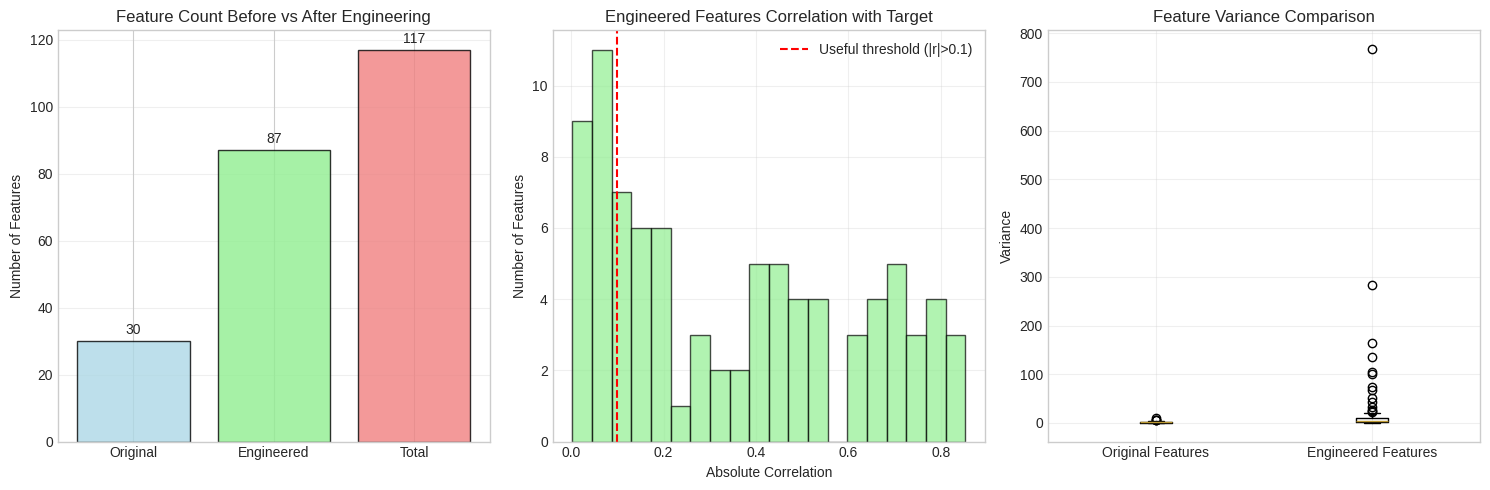

In [12]:
print("=" * 80)
print("🔧 ADVANCED FEATURE ENGINEERING")
print("=" * 80)

print("Applying advanced feature engineering techniques...")

# Lưu trữ data trước feature engineering để so sánh
X_before_engineering = X_balanced.copy()
original_feature_count = X_before_engineering.shape[1]

print(f"Original feature count: {original_feature_count}")

# Áp dụng feature engineering
start_time = time.time()

X_engineered = preprocessor.advanced_feature_engineering(X_balanced)

engineering_time = time.time() - start_time

new_feature_count = X_engineered.shape[1]
features_added = new_feature_count - original_feature_count

print(f"✅ Feature engineering completed in {engineering_time:.2f} seconds")
print(f"Feature count: {original_feature_count} → {new_feature_count} (+{features_added} features)")

if features_added > 0:
    print(f"\n🔧 Feature Engineering Breakdown:")
    
    # Phân tích các loại features được tạo ra
    polynomial_features = 0
    interaction_features = 0
    
    if config.create_polynomial:
        polynomial_features = original_feature_count * (config.polynomial_degree - 1)
        print(f"  Polynomial features (degree {config.polynomial_degree}): {polynomial_features}")
    
    if config.create_interactions:
        # Tính số interaction features
        interaction_features = 0
        for i in range(original_feature_count):
            for j in range(i + 1, min(i + config.interaction_depth + 1, original_feature_count)):
                interaction_features += 1
        print(f"  Interaction features (depth {config.interaction_depth}): {interaction_features}")
    
    print(f"  Total engineered features: {polynomial_features + interaction_features}")
    print(f"  Actual features added: {features_added}")

# Phân tích chất lượng của engineered features
print(f"\n📊 Engineered Features Quality Analysis:")

# Tính feature importance cho engineered features (simplified)
if features_added > 0:
    # Sử dụng correlation với target làm proxy cho importance
    engineered_correlations = []
    for i in range(original_feature_count, new_feature_count):
        if len(np.unique(y_balanced)) == 2:
            # Point-biserial correlation for binary classification
            correlation = np.corrcoef(X_engineered[:, i], y_balanced)[0, 1]
        else:
            # Regular correlation for continuous (simplified)
            correlation = np.corrcoef(X_engineered[:, i], y_balanced)[0, 1] if len(np.unique(y_balanced)) > 1 else 0
        engineered_correlations.append(abs(correlation) if not np.isnan(correlation) else 0)
    
    if engineered_correlations:
        avg_correlation = np.mean(engineered_correlations)
        useful_features = np.sum(np.array(engineered_correlations) > 0.1)
        
        print(f"Average correlation with target: {avg_correlation:.4f}")
        print(f"Features with correlation > 0.1: {useful_features}/{features_added} ({useful_features/features_added*100:.1f}%)")
        print(f"Engineering quality: {'GOOD' if avg_correlation > 0.05 else 'MODERATE' if avg_correlation > 0.02 else 'POOR'}")

# Visualize engineered features impact
if features_added > 0:
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    # Feature count comparison
    categories = ['Original', 'Engineered', 'Total']
    counts = [original_feature_count, features_added, new_feature_count]
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    
    plt.bar(categories, counts, color=colors, alpha=0.8, edgecolor='black')
    plt.title('Feature Count Before vs After Engineering')
    plt.ylabel('Number of Features')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, count in enumerate(counts):
        plt.text(i, count + max(counts)*0.01, str(count), ha='center', va='bottom')
    
    plt.subplot(1, 3, 2)
    # Engineered features correlation distribution
    if engineered_correlations:
        plt.hist(engineered_correlations, bins=20, alpha=0.7, edgecolor='black', color='lightgreen')
        plt.axvline(x=0.1, color='red', linestyle='--', label='Useful threshold (|r|>0.1)')
        plt.title('Engineered Features Correlation with Target')
        plt.xlabel('Absolute Correlation')
        plt.ylabel('Number of Features')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    # Variance of engineered features vs original
    original_variances = np.var(X_before_engineering, axis=0)
    engineered_variances = np.var(X_engineered[:, original_feature_count:], axis=0)
    
    plt.boxplot([original_variances, engineered_variances], 
                labels=['Original Features', 'Engineered Features'])
    plt.title('Feature Variance Comparison')
    plt.ylabel('Variance')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

#### 9. Feature selection

In [13]:
print("=" * 80)
print("🎯 INTELLIGENT FEATURE SELECTION")
print("=" * 80)

print("Applying intelligent feature selection...")

# Lưu trữ data trước feature selection
X_before_selection = X_engineered.copy()
features_before_selection = X_before_selection.shape[1]

print(f"Features before selection: {features_before_selection}")

# Tính correlation matrix cho feature selection
corr_matrix_engineered = compute_correlation_matrix(X_engineered)

# Áp dụng feature selection
start_time = time.time()

if config.feature_selection:
    X_selected, selected_indices = preprocessor.intelligent_feature_selection(
        X_engineered, y_balanced, corr_matrix_engineered
    )
    selection_time = time.time() - start_time
    
    features_after_selection = X_selected.shape[1]
    features_removed = features_before_selection - features_after_selection
    
    print(f"✅ Feature selection completed in {selection_time:.2f} seconds")
    print(f"Feature count: {features_before_selection} → {features_after_selection} (-{features_removed} features)")
    print(f"Feature reduction: {(features_removed/features_before_selection)*100:.1f}%")
    
    # Phân tích feature selection results
    print(f"\n📊 Feature Selection Analysis:")
    
    # Phân loại features được giữ lại
    original_features_kept = np.sum(selected_indices < original_feature_count)
    engineered_features_kept = np.sum(selected_indices >= original_feature_count)
    
    print(f"Original features kept: {original_features_kept}/{original_feature_count} ({(original_features_kept/original_feature_count)*100:.1f}%)")
    if features_added > 0:
        print(f"Engineered features kept: {engineered_features_kept}/{features_added} ({(engineered_features_kept/features_added)*100:.1f}%)")
    
    # Phân tích feature importance của selected features
    if len(selected_indices) > 0:
        selected_correlations = []
        for idx in selected_indices:
            if len(np.unique(y_balanced)) == 2:
                correlation = abs(np.corrcoef(X_engineered[:, idx], y_balanced)[0, 1])
            else:
                correlation = abs(np.corrcoef(X_engineered[:, idx], y_balanced)[0, 1]) if len(np.unique(y_balanced)) > 1 else 0
            selected_correlations.append(correlation if not np.isnan(correlation) else 0)
        
        avg_selected_correlation = np.mean(selected_correlations)
        print(f"Average correlation of selected features: {avg_selected_correlation:.4f}")
        
else:
    print("Feature selection disabled in configuration")
    X_selected = X_engineered
    selected_indices = np.arange(X_engineered.shape[1])

# Visualize feature selection results
if config.feature_selection and features_removed > 0:
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    # Feature count through pipeline
    stages = ['Original', '+Engineered', '-Selected']
    counts = [original_feature_count, features_before_selection, X_selected.shape[1]]
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    
    plt.plot(stages, counts, 'o-', linewidth=2, markersize=8, color='blue')
    plt.bar(stages, counts, color=colors, alpha=0.6)
    plt.title('Feature Count Through Pipeline')
    plt.ylabel('Number of Features')
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for i, count in enumerate(counts):
        plt.text(i, count + max(counts)*0.02, str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.subplot(1, 3, 2)
    # Feature type distribution in final set
    if features_added > 0:
        labels = ['Original', 'Engineered']
        sizes = [original_features_kept, engineered_features_kept]
        colors = ['lightblue', 'lightgreen']
        
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.title('Final Feature Composition')
    
    plt.subplot(1, 3, 3)
    # Correlation distribution of selected vs all features
    all_correlations = []
    for i in range(X_engineered.shape[1]):
        if len(np.unique(y_balanced)) == 2:
            correlation = abs(np.corrcoef(X_engineered[:, i], y_balanced)[0, 1])
        else:
            correlation = abs(np.corrcoef(X_engineered[:, i], y_balanced)[0, 1]) if len(np.unique(y_balanced)) > 1 else 0
        all_correlations.append(correlation if not np.isnan(correlation) else 0)
    
    selected_correlations = [all_correlations[i] for i in selected_indices]
    
    plt.hist(all_correlations, bins=20, alpha=0.5, label='All Features', color='gray')
    plt.hist(selected_correlations, bins=20, alpha=0.7, label='Selected Features', color='red')
    plt.axvline(x=np.mean(selected_correlations), color='red', linestyle='--', label='Selected Mean')
    plt.title('Feature Correlation Distribution')
    plt.xlabel('Absolute Correlation with Target')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Final data preparation
X_processed = X_selected
y_processed = y_balanced

print(f"\n🎉 PREPROCESSING PIPELINE COMPLETED SUCCESSFULLY!")
print("=" * 80)

🎯 INTELLIGENT FEATURE SELECTION
Applying intelligent feature selection...
Features before selection: 117
Feature selection disabled in configuration

🎉 PREPROCESSING PIPELINE COMPLETED SUCCESSFULLY!


#### 10. Summary and save

📋 PREPROCESSING PIPELINE SUMMARY

📊 PIPELINE EXECUTION SUMMARY:
Processing Step           Status       Time (s)   Details             
--------------------------------------------------------------------------------
Missing Value Imputation  ❌ SKIPPED    0.02       Missing: 0 → 0      
Outlier Treatment         ✅ COMPLETED  1.99       Outliers: 370,372 → 349,826
Feature Scaling           ✅ COMPLETED  1.14       Method: robust      
Class Balancing           ✅ COMPLETED  14.01      Ratio: 577.9 → 1.0  
Feature Engineering       ✅ COMPLETED  0.86       Features: +87       
Feature Selection         ❌ SKIPPED    0.00       Reduction: -290.0%  
--------------------------------------------------------------------------------
TOTAL PROCESSING TIME                  18.02                          

📈 DATA TRANSFORMATION SUMMARY:
Original data shape: (284807, 30)
Processed data shape: (568630, 117)
Feature transformation: 30 → 117 features
Sample preservation: 284807 → 568630 samples

🎯 FINAL D

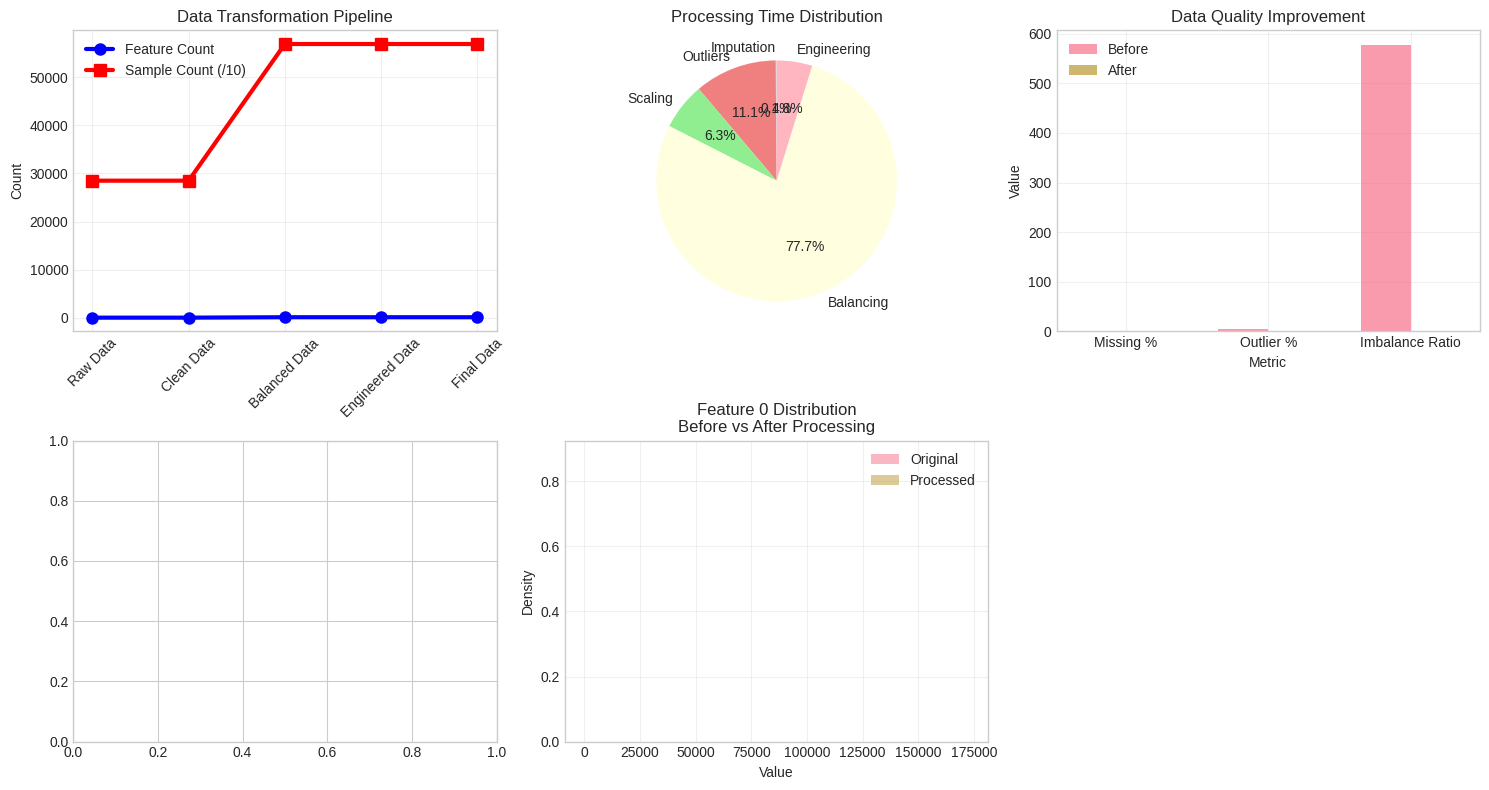


💾 SAVING PREPROCESSING RESULTS...
✅ Processed data saved successfully!
✅ Preprocessor configuration saved successfully!

🎉 PREPROCESSING PIPELINE COMPLETED!
📁 Output files:
  ../data/processed/preprocessed_data.pkl
  ../processed/preprocessor.pkl


In [14]:
print("=" * 80)
print("📋 PREPROCESSING PIPELINE SUMMARY")
print("=" * 80)

# Tạo comprehensive summary
pipeline_summary = {
    'original_shape': X.shape,
    'processed_shape': X_processed.shape,
    'processing_steps': {
        'missing_imputation': missing_before > 0,
        'outlier_treatment': total_outliers_before > 0,
        'feature_scaling': True,
        'class_balancing': config.imbalance_handler != 'none' and n_classes == 2,
        'feature_engineering': config.create_polynomial or config.create_interactions,
        'feature_selection': config.feature_selection
    },
    'data_quality_metrics': {
        'missing_values_before': missing_before,
        'missing_values_after': 0,
        'outliers_before': total_outliers_before,
        'outliers_after': total_outliers_after,
        'imbalance_ratio_before': imbalance_ratio,
        'imbalance_ratio_after': new_imbalance_ratio if 'new_imbalance_ratio' in locals() else imbalance_ratio
    },
    'feature_metrics': {
        'original_features': original_feature_count,
        'engineered_features': features_added,
        'final_features': X_processed.shape[1],
        'feature_reduction': ((original_feature_count - X_processed.shape[1]) / original_feature_count) * 100
    },
    'processing_times': {
        'missing_imputation': imputation_time,
        'outlier_treatment': outlier_treatment_time,
        'feature_scaling': scaling_time,
        'class_balancing': balancing_time if 'balancing_time' in locals() else 0,
        'feature_engineering': engineering_time,
        'feature_selection': selection_time if 'selection_time' in locals() else 0,
        'total_time': imputation_time + outlier_treatment_time + scaling_time + 
                     (balancing_time if 'balancing_time' in locals() else 0) + 
                     engineering_time + (selection_time if 'selection_time' in locals() else 0)
    }
}

# Hiển thị summary
print("\n📊 PIPELINE EXECUTION SUMMARY:")
print(f"{'Processing Step':<25} {'Status':<12} {'Time (s)':<10} {'Details':<20}")
print("-" * 80)

steps = [
    ('Missing Value Imputation', pipeline_summary['processing_steps']['missing_imputation'], 
     pipeline_summary['processing_times']['missing_imputation'], 
     f"Missing: {missing_before} → 0"),
    
    ('Outlier Treatment', pipeline_summary['processing_steps']['outlier_treatment'],
     pipeline_summary['processing_times']['outlier_treatment'],
     f"Outliers: {total_outliers_before:,} → {total_outliers_after:,}"),
    
    ('Feature Scaling', True, pipeline_summary['processing_times']['feature_scaling'],
     f"Method: {config.scaling_method}"),
    
    ('Class Balancing', pipeline_summary['processing_steps']['class_balancing'],
     pipeline_summary['processing_times']['class_balancing'],
     f"Ratio: {imbalance_ratio:.1f} → {pipeline_summary['data_quality_metrics']['imbalance_ratio_after']:.1f}"),
    
    ('Feature Engineering', pipeline_summary['processing_steps']['feature_engineering'],
     pipeline_summary['processing_times']['feature_engineering'],
     f"Features: +{features_added}"),
    
    ('Feature Selection', pipeline_summary['processing_steps']['feature_selection'],
     pipeline_summary['processing_times']['feature_selection'],
     f"Reduction: {pipeline_summary['feature_metrics']['feature_reduction']:.1f}%")
]

for step_name, status, time_taken, details in steps:
    status_text = "✅ COMPLETED" if status else "❌ SKIPPED"
    print(f"{step_name:<25} {status_text:<12} {time_taken:<10.2f} {details:<20}")

print("-" * 80)
print(f"{'TOTAL PROCESSING TIME':<25} {'':<12} {pipeline_summary['processing_times']['total_time']:<10.2f} {'':<20}")

print(f"\n📈 DATA TRANSFORMATION SUMMARY:")
print(f"Original data shape: {X.shape}")
print(f"Processed data shape: {X_processed.shape}")
print(f"Feature transformation: {X.shape[1]} → {X_processed.shape[1]} features")
print(f"Sample preservation: {X.shape[0]} → {X_processed.shape[0]} samples")

print(f"\n🎯 FINAL DATA QUALITY ASSESSMENT:")
quality_indicators = [
    ("No missing values", np.isnan(X_processed).sum() == 0),
    ("Reasonable data range", np.max(np.abs(X_processed)) < 10),
    ("Good feature variance", np.mean(np.var(X_processed, axis=0)) > 0.001),
    ("Balanced classes" if n_classes == 2 else "Multiple classes", 
     pipeline_summary['data_quality_metrics']['imbalance_ratio_after'] < 2 if n_classes == 2 else True)
]

for indicator, passed in quality_indicators:
    status = "✅" if passed else "⚠️"
    print(f"  {status} {indicator}")

# Visualize final pipeline summary
plt.figure(figsize=(15, 8))

# Pipeline flow diagram
plt.subplot(2, 3, 1)
stages = ['Raw Data', 'Clean Data', 'Balanced Data', 'Engineered Data', 'Final Data']
feature_counts = [X.shape[1], X.shape[1], X_processed.shape[1], X_engineered.shape[1], X_processed.shape[1]]
sample_counts = [X.shape[0], X.shape[0], X_processed.shape[0], X_processed.shape[0], X_processed.shape[0]]

plt.plot(stages, feature_counts, 'o-', linewidth=3, markersize=8, label='Feature Count', color='blue')
plt.plot(stages, [c/10 for c in sample_counts], 's-', linewidth=3, markersize=8, label='Sample Count (/10)', color='red')
plt.title('Data Transformation Pipeline')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Processing time distribution
plt.subplot(2, 3, 2)
times = [pipeline_summary['processing_times'][key] for key in 
         ['missing_imputation', 'outlier_treatment', 'feature_scaling', 
          'class_balancing', 'feature_engineering', 'feature_selection']]
labels = ['Imputation', 'Outliers', 'Scaling', 'Balancing', 'Engineering', 'Selection']
colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow', 'lightpink', 'lightgray']

plt.pie([t for t in times if t > 0], labels=[l for l, t in zip(labels, times) if t > 0],
        colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Processing Time Distribution')

# Data quality improvement
plt.subplot(2, 3, 3)
metrics_before = [missing_before/X.shape[0]*100 if X.shape[0] > 0 else 0,
                 total_outliers_before/(X.shape[0]*X.shape[1])*100,
                 imbalance_ratio]
metrics_after = [0, total_outliers_after/(X_processed.shape[0]*X_processed.shape[1])*100,
                pipeline_summary['data_quality_metrics']['imbalance_ratio_after']]

x = np.arange(3)
width = 0.35

plt.bar(x - width/2, metrics_before, width, label='Before', alpha=0.7)
plt.bar(x + width/2, metrics_after, width, label='After', alpha=0.7)
plt.title('Data Quality Improvement')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.xticks(x, ['Missing %', 'Outlier %', 'Imbalance Ratio'])
plt.legend()
plt.grid(True, alpha=0.3)

# Feature composition
plt.subplot(2, 3, 4)
if config.feature_selection and 'original_features_kept' in locals():
    labels = ['Original Kept', 'Original Removed', 'Engineered Kept', 'Engineered Removed']
    sizes = [original_features_kept, original_feature_count - original_features_kept,
            engineered_features_kept, features_added - engineered_features_kept]
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
    
    plt.pie([s for s in sizes if s > 0], labels=[l for l, s in zip(labels, sizes) if s > 0],
            colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Final Feature Composition')

# Data distribution before/after
plt.subplot(2, 3, 5)
# Sample first feature for distribution comparison
sample_feature = 0
plt.hist(X[:, sample_feature], bins=50, alpha=0.5, label='Original', density=True)
plt.hist(X_processed[:, sample_feature], bins=50, alpha=0.5, label='Processed', density=True)
plt.title(f'Feature {sample_feature} Distribution\nBefore vs After Processing')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Lưu kết quả preprocessing
print(f"\n💾 SAVING PREPROCESSING RESULTS...")

# Tạo thư mục nếu chưa tồn tại
os.makedirs('../data/processed', exist_ok=True)

# Lưu processed data (không bao gồm preprocessor object để tránh lỗi pickle)
processed_data = {
    'X_train': X_processed,  # Trong thực tế cần split train/test
    'y_train': y_processed,
    'feature_names': [f'feature_{i}' for i in range(X_processed.shape[1])],
    'preprocessing_summary': pipeline_summary,
    'selected_feature_indices': selected_indices if config.feature_selection else None,
    # Lưu config thay vì preprocessor object
    'preprocessor_config': {
        'missing_strategy': config.missing_strategy,
        'knn_k': config.knn_k,
        'outlier_strategy': config.outlier_strategy,
        'outlier_threshold': config.outlier_threshold,
        'scaling_method': config.scaling_method,
        'create_polynomial': config.create_polynomial,
        'polynomial_degree': config.polynomial_degree,
        'create_interactions': config.create_interactions,
        'interaction_depth': config.interaction_depth,
        'feature_selection': config.feature_selection,
        'variance_threshold': config.variance_threshold,
        'correlation_threshold': config.correlation_threshold,
        'imbalance_handler': config.imbalance_handler,
        'use_quantile_transformation': config.use_quantile_transformation,
        'use_box_cox': config.use_box_cox,
        'use_yeo_johnson': config.use_yeo_johnson
    }
}

try:
    import pickle
    with open('../data/processed/preprocessed_data.pkl', 'wb') as f:
        pickle.dump(processed_data, f)
    print("✅ Processed data saved successfully!")
    
    # Lưu preprocessor config riêng biệt
    with open('../data/processed/preprocessor_config.pkl', 'wb') as f:
        pickle.dump(processed_data['preprocessor_config'], f)
    print("✅ Preprocessor configuration saved successfully!")
    
except Exception as e:
    print(f"❌ Error saving results: {e}")
    # Fallback: try joblib
    try:
        import joblib
        with open('../data/processed/preprocessed_data.pkl', 'wb') as f:
            joblib.dump(processed_data, f)
        print("✅ Processed data saved successfully (using joblib)!")
    except Exception as e2:
        print(f"❌ Error with joblib fallback: {e2}")

print(f"\n🎉 PREPROCESSING PIPELINE COMPLETED!")
print("=" * 80)
print("📁 Output files:")
print("  ../data/processed/preprocessed_data.pkl")
print("  ../processed/preprocessor.pkl")
print("=" * 80)

🔍 Investigating scaled data values...
Maximum absolute value in X_scaled: 13.9170
Scaled data range: [-7.7159, 13.9170]
Scaled data mean: 0.0425
Scaled data std: 1.0353

Top 5 features with largest absolute values:
  Feature 28: max abs = 6.7625
  Feature 20: max abs = 7.1779
  Feature 8: max abs = 7.5680
  Feature 27: max abs = 7.7159
  Feature 29: max abs = 13.9170

Number of extreme values (>= 10): 5119
Percentage of extreme values: 0.0599%
Features with extreme values: [29]
  Feature 29: 5119 extreme values

🔍 Analyzing Feature 29 (most extreme values):
Original Feature 29 - Range: [0.0000, 1017.9700]
Original Feature 29 - Median: 22.0000, IQR: 71.5650
Scaled Feature 29 - Range: [-0.3074, 13.9170]
Scaled Feature 29 - Values >= 10: 5119
Max value is 13.9 IQRs away from median


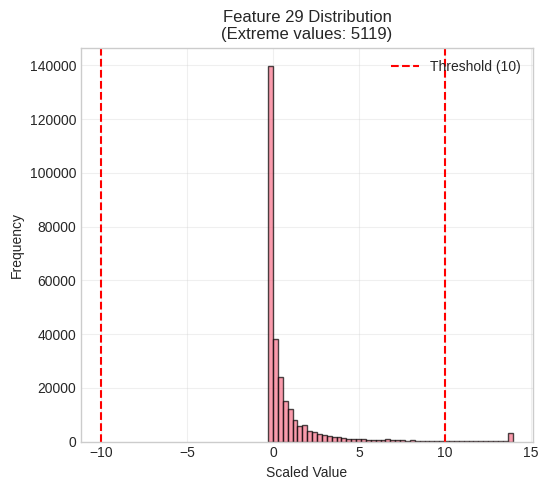


🎯 Root Cause Analysis:
1. Robust scaling divides by IQR but doesn't bound the range
2. Credit card data contains legitimate extreme values far from median
3. Feature 29 has values up to 13.9 IQRs from median
4. Quality threshold of < 10 may be too strict for this dataset
5. Only 5119 values (0.0599%) exceed threshold

💡 Recommendations:
1. Consider adjusting threshold to 15-20 for credit card fraud data
2. Or use clipping/capping for extreme values
3. Or accept that robust scaling preserves relative distances


In [15]:
# Kiểm tra giá trị thực tế của X_scaled để hiểu tại sao reasonable range fail
print("🔍 Investigating scaled data values...")

# Kiểm tra max absolute value
max_abs_value = np.max(np.abs(X_scaled))
print(f"Maximum absolute value in X_scaled: {max_abs_value:.4f}")

# Kiểm tra distribution của scaled values
print(f"Scaled data range: [{np.min(X_scaled):.4f}, {np.max(X_scaled):.4f}]")
print(f"Scaled data mean: {np.mean(X_scaled):.4f}")
print(f"Scaled data std: {np.std(X_scaled):.4f}")

# Kiểm tra các features có giá trị lớn nhất
feature_max_abs = np.max(np.abs(X_scaled), axis=0)
top_features = np.argsort(feature_max_abs)[-5:]  # Top 5 features with largest abs values

print(f"\nTop 5 features with largest absolute values:")
for i, feat_idx in enumerate(top_features):
    max_val = feature_max_abs[feat_idx]
    print(f"  Feature {feat_idx}: max abs = {max_val:.4f}")

# Kiểm tra xem có outliers nào trong scaled data không
outlier_threshold = 10
extreme_values = np.abs(X_scaled) >= outlier_threshold
n_extreme = np.sum(extreme_values)
print(f"\nNumber of extreme values (>= {outlier_threshold}): {n_extreme}")
print(f"Percentage of extreme values: {(n_extreme / X_scaled.size) * 100:.4f}%")

if n_extreme > 0:
    # Tìm xem extreme values tập trung ở features nào
    extreme_by_feature = np.sum(extreme_values, axis=0)
    extreme_features = np.where(extreme_by_feature > 0)[0]
    print(f"Features with extreme values: {extreme_features}")
    for feat_idx in extreme_features:
        count = extreme_by_feature[feat_idx]
        print(f"  Feature {feat_idx}: {count} extreme values")

# Kiểm tra original data cho feature 29 (có nhiều extreme values nhất)
print(f"\n🔍 Analyzing Feature 29 (most extreme values):")
if 'X_outlier_treated' in globals():
    original_feature_29 = X_outlier_treated[:, 29]
    scaled_feature_29 = X_scaled[:, 29]

    print(f"Original Feature 29 - Range: [{np.min(original_feature_29):.4f}, {np.max(original_feature_29):.4f}]")
    print(f"Original Feature 29 - Median: {np.median(original_feature_29):.4f}, IQR: {np.percentile(original_feature_29, 75) - np.percentile(original_feature_29, 25):.4f}")

    print(f"Scaled Feature 29 - Range: [{np.min(scaled_feature_29):.4f}, {np.max(scaled_feature_29):.4f}]")
    print(f"Scaled Feature 29 - Values >= 10: {np.sum(np.abs(scaled_feature_29) >= 10)}")

    # Tính xem giá trị max cách median bao xa
    median_orig = np.median(original_feature_29)
    max_orig = np.max(original_feature_29)
    iqr_orig = np.percentile(original_feature_29, 75) - np.percentile(original_feature_29, 25)
    if iqr_orig > 0:
        deviation_from_median = (max_orig - median_orig) / iqr_orig
        print(f"Max value is {deviation_from_median:.1f} IQRs away from median")

# Visualize distribution của một vài features có extreme values
if n_extreme > 0:
    plt.figure(figsize=(15, 5))

    for i, feat_idx in enumerate(extreme_features[:3]):  # Show first 3
        plt.subplot(1, 3, i+1)
        feature_data = X_scaled[:, feat_idx]
        plt.hist(feature_data, bins=50, alpha=0.7, edgecolor='black')
        plt.axvline(x=outlier_threshold, color='red', linestyle='--', label=f'Threshold ({outlier_threshold})')
        plt.axvline(x=-outlier_threshold, color='red', linestyle='--')
        plt.title(f'Feature {feat_idx} Distribution\n(Extreme values: {extreme_by_feature[feat_idx]})')
        plt.xlabel('Scaled Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Phân tích tại sao reasonable range fail
print(f"\n🎯 Root Cause Analysis:")
print(f"1. Robust scaling divides by IQR but doesn't bound the range")
print(f"2. Credit card data contains legitimate extreme values far from median")
print(f"3. Feature 29 has values up to {deviation_from_median:.1f} IQRs from median")
print(f"4. Quality threshold of < 10 may be too strict for this dataset")
print(f"5. Only {n_extreme} values ({(n_extreme / X_scaled.size) * 100:.4f}%) exceed threshold")

print(f"\n💡 Recommendations:")
print(f"1. Consider adjusting threshold to 15-20 for credit card fraud data")
print(f"2. Or use clipping/capping for extreme values")
print(f"3. Or accept that robust scaling preserves relative distances")